In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
import importlib
from src.plotting import set_plot_style
from src.baseline_utils import *
from src.eda import *
from src.config import DATA_DIR, FIGURES_DIR
from src.timeseries_utils import *
set_plot_style()

In [3]:
df = pd.read_csv(DATA_DIR / "processed" / "federal_df.csv", parse_dates=['EventDate'], low_memory=False)

In [33]:
df.head(10)

,ID,UPA,EventDate,Employer,Address1,City,State,Zip,Latitude,Longitude,...,Part of Body Title,Event,EventTitle,Source,SourceTitle,FederalState,Year,NatureGroup,NatureGroupLabel,BodyPartDivision
0,2015010015,931176,2015-01-01,FCI Otisville Federal Correctional Institution,Two Mile Drive,OTISVILLE,NEW YORK,10963.0,41.46,-74.53,...,Lower leg(s),1214,Injured by physical contact with person while ...,5721,Co-worker,1,2015,11,Unspecified traumatic injuries,Lower Extremities
1,2015010016,930267,2015-01-01,Kalahari Manufacturing LLC,171 Progress Drive,LAKE DELTON,WISCONSIN,53940.0,43.59,-89.79,...,"Leg(s), n.e.c.",317,"Ignition of vapors, gases, or liquids",7261,"Welding, cutting, and blow torches",1,2015,15,Sprains/Strains/Tears,Lower Extremities
2,2015010018,929823,2015-01-01,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,CORAOPOLIS,PENNSYLVANIA,15108.0,40.49,-80.11,...,Nonclassifiable,4331,Other fall to lower level less than 6 feet,8421,"Semi, tractor-trailer, tanker truck",1,2015,10,Other/Unclassified,Other/Unclassified
3,2015010019,929711,2015-01-01,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,MACON,GEORGIA,31206.0,32.77,-83.65,...,"Leg(s), unspecified",640,Caught in or compressed by equipment or object...,8623,Pallet jack-powered,1,2015,19,Other traumatic injuries,Lower Extremities
4,2015010020,929642,2015-01-01,North American Pipe Corporation,210 South Arch Street,JANESVILLE,WISCONSIN,53545.0,42.67,-89.04,...,"Finger(s), fingernail(s), n.e.c.",6411,Caught in running equipment or machinery durin...,350,"Metal, woodworking, and special material machi...",1,2015,11,Unspecified traumatic injuries,Upper Extremities
5,2015010021,929709,2015-01-01,"The Home Depot, Inc.",3031 NE Pine Island Road,CAPE CORAL,FLORIDA,33909.0,26.68,-81.91,...,Elbow(s),422,Fall on same level due to slipping,660,"Floors, walkways, ground surfaces, unspecified",1,2015,19,Other traumatic injuries,Upper Extremities
6,2015010022,932133,2015-01-01,Gopher Resource,6505 Jewel Ave,TAMPA,FLORIDA,33619.0,27.96,-82.38,...,Fingertip(s),6412,Caught in running equipment or machinery durin...,370,"Special process machinery, unspecified",1,2015,13,Fractures,Upper Extremities
7,2015010023,930028,2015-01-02,"Foster Trucking, Inc.","Wells Ranch, 3314-225-228, Tank Battery",GILL,COLORADO,80624.0,40.47,-104.51,...,Nonclassifiable,9999,Nonclassifiable,9999,Nonclassifiable,1,2015,15,Sprains/Strains/Tears,Other/Unclassified
8,2015010024,930006,2015-01-02,Trinidad Drilling,38734 S CR 200,WOODWARD,OKLAHOMA,73801.0,36.42,-99.43,...,Nonclassifiable,620,"Struck by object or equipment, unspecified",4813,"Tires, except bike",1,2015,10,Other/Unclassified,Other/Unclassified
9,2015010025,933583,2015-01-02,The Krystal Company,6201 West Colonial Drive,ORLANDO,FLORIDA,32808.0,28.55,-81.46,...,Fingertip(s),6252,Injured by slipping or swinging object held by...,7125,"Knives, unspecified or n.e.c.",1,2015,13,Fractures,Upper Extremities


In [4]:
monthly_global = aggregate_monthly_global(
    df,
    date_col="EventDate",
    target_cols=["Hospitalized", "Amputation"],
    freq="MS",
    agg="sum",   # counts per month
)

# Focus on the hospitalized global series for now
y_hosp = monthly_global["Hospitalized"]


In [5]:
print(y_hosp.head())

EventDate
2015-01-01    673
2015-02-01    623
2015-03-01    664
2015-04-01    612
2015-05-01    611
Freq: MS, Name: Hospitalized, dtype: int64


## Statistical Models (ETS, ARIMA, SARIMA)

In [8]:


# (Optional) restrict to pre-2024 data for order selection:
y_hosp_train = y_hosp.loc[: "2023-12-01"]

# 2. ARIMA order search (non-seasonal)
arima_results, best_arima_order = find_best_arima(
    y=y_hosp_train,
    ic="aic",
)

print("Best ARIMA order:", best_arima_order)
print(arima_results.head())

# 3. SARIMA order search (seasonal with yearly period m=12)
sarima_results, best_order, best_seasonal_order = find_best_sarima(
    y=y_hosp_train,
    ic="aic",
    m=12,
)

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)
print(sarima_results.head())


Best ARIMA order: (3, 1, 3)
       order seasonal_order          aic          bic
0  (3, 1, 3)           None  1160.171594  1178.614697
1  (0, 1, 3)           None  1161.059571  1171.598486
2  (1, 1, 3)           None  1162.863519  1176.037164
3  (2, 1, 3)           None  1163.539973  1179.348347
4  (0, 2, 3)           None  1163.795417  1174.295308
Best SARIMA order: (0, 1, 2)
Best seasonal order: (0, 1, 1, 12)
       order seasonal_order         aic         bic
0  (0, 1, 2)  (0, 1, 1, 12)  877.446780  886.974887
1  (1, 1, 2)  (0, 1, 1, 12)  878.772180  890.682313
2  (0, 1, 2)  (1, 1, 1, 12)  879.435711  891.345844
3  (1, 1, 2)  (1, 1, 1, 12)  880.748777  895.040936
4  (2, 1, 2)  (0, 1, 1, 12)  880.993685  895.285844


In [9]:



# -----------------------
# Metrics
# -----------------------

def mae_rmse(y_true: pd.Series, y_pred: pd.Series) -> dict:
    """
    Compute MAE and RMSE between two aligned series.
    """
    mask = ~y_true.isna() & ~y_pred.isna()
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    return {"MAE": mae, "RMSE": rmse}


In [10]:
# -----------------------
# Rolling 1-step forecast
# -----------------------

def rolling_1step_forecast_sarimax(
    y: pd.Series,
    test_index: pd.DatetimeIndex,
    order: tuple[int, int, int],
    seasonal_order: Optional[tuple[int, int, int, int]] = None,
    enforce_stationarity: bool = False,
    enforce_invertibility: bool = False,
) -> pd.Series:
    """
    Expanding-window 1-step-ahead forecasts for SARIMAX-type models
    (includes plain ARIMA when seasonal_order is None).

    Parameters
    ----------
    y : pd.Series
        Full series (train+test), DatetimeIndex with a fixed monthly freq.
    test_index : DatetimeIndex
        Index of test timestamps to forecast.
    order : (p, d, q)
    seasonal_order : (P, D, Q, m) or None

    Returns
    -------
    preds : pd.Series
        1-step-ahead forecasts on test_index.
    """
    preds = []

    # Try to infer frequency
    freq = y.index.freq or pd.infer_freq(y.index) or "MS"
    offset = pd.tseries.frequencies.to_offset(freq)

    for t in test_index:
        # use data up to t - 1 step
        end_train = t - offset
        y_window = y.loc[:end_train]

        model = sm.tsa.statespace.SARIMAX(
            y_window,
            order=order,
            seasonal_order=seasonal_order if seasonal_order is not None else (0, 0, 0, 0),
            enforce_stationarity=enforce_stationarity,
            enforce_invertibility=enforce_invertibility,
        )

        fitted = model.fit(disp=False)
        fc = fitted.forecast(steps=1)
        preds.append(fc.iloc[0])

    preds = pd.Series(preds, index=test_index, name="forecast")
    return preds


In [12]:
# -----------------------
# ETS (Exponential Smoothing)
# -----------------------

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def fit_evaluate_ets(
    y: pd.Series,
    train_end: str = "2023-12-01",
    trend: Optional[str] = "add",
    seasonal: Optional[str] = "add",
    seasonal_periods: int = 12,
):
    """
    Fit an ETS model (Holt-Winters) and evaluate on train+test.

    Returns a dict with model, predictions, and metrics.
    """
    y = y.sort_index()
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]   # drop train_end itself

    # Fit on full train
    ets_model = ExponentialSmoothing(
        y_train,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
    )
    ets_fit = ets_model.fit(optimized=True)

    # In-sample fittedvalues are effectively 1-step-ahead for train
    train_pred = ets_fit.fittedvalues
    train_metrics = mae_rmse(y_train, train_pred)

    # Rolling 1-step-ahead for test (refit each step)
    freq = y.index.freq or pd.infer_freq(y.index) or "MS"
    offset = pd.tseries.frequencies.to_offset(freq)

    test_preds = []
    for t in y_test.index:
        end_train = t - offset
        y_window = y.loc[:end_train]

        model = ExponentialSmoothing(
            y_window,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
        )
        fit = model.fit(optimized=True)
        fc = fit.forecast(1)
        test_preds.append(fc.iloc[0])

    test_pred = pd.Series(test_preds, index=y_test.index, name="forecast")
    test_metrics = mae_rmse(y_test, test_pred)

    return {
        "model_name": "ETS",
        "fit": ets_fit,
        "train_true": y_train,
        "train_pred": train_pred,
        "test_true": y_test,
        "test_pred": test_pred,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
    }


In [28]:
# -----------------------
# ARIMA
# -----------------------

def fit_evaluate_arima(
    y: pd.Series,
    order: tuple[int, int, int] = (3, 1, 3),
    train_end: str = "2023-12-01",
):
    """
    Fit an ARIMA model (as SARIMAX with no seasonal part) and evaluate.
    """
    y = y.sort_index()
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]   # 2024 monthly

    # Fit single model on full train for in-sample predictions
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fit = model.fit(disp=False)

    # In-sample one-step-ahead predictions for train
    
    train_pred = fit.get_prediction(dynamic=False).predicted_mean
    train_pred = train_pred.loc[y_train.index]   # align to actual train dates

    train_metrics = mae_rmse(y_train, train_pred)

    # 1-step-ahead rolling forecast on test (expanding window)
    test_pred = rolling_1step_forecast_sarimax(
        y=y,
        test_index=y_test.index,
        order=order,
        seasonal_order=None,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    test_metrics = mae_rmse(y_test, test_pred)

    return {
        "model_name": f"ARIMA{order}",
        "fit": fit,
        "train_true": y_train,
        "train_pred": train_pred,
        "test_true": y_test,
        "test_pred": test_pred,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
    }


In [20]:
# -----------------------
# SARIMA
# -----------------------

def fit_evaluate_sarima(
    y: pd.Series,
    order: tuple[int, int, int] = (1, 0, 1),
    seasonal_order: tuple[int, int, int, int] = (1, 1, 1, 12),
    train_end: str = "2023-12-01",
):
    """
    Fit a SARIMA model and evaluate on train+test.
    """
    y = y.sort_index()
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]   # 2024 monthly

    # Fit single model on full train for in-sample predictions
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fit = model.fit(disp=False)

    # In-sample one-step-ahead predictions
    train_pred = fit.get_prediction(start=y_train.index[0], end=y_train.index[-1], dynamic=False).predicted_mean
    train_metrics = mae_rmse(y_train, train_pred)

    # 1-step-ahead rolling forecast on test (expanding window)
    test_pred = rolling_1step_forecast_sarimax(
        y=y,
        test_index=y_test.index,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    test_metrics = mae_rmse(y_test, test_pred)

    return {
        "model_name": f"SARIMA{order}x{seasonal_order}",
        "fit": fit,
        "train_true": y_train,
        "train_pred": train_pred,
        "test_true": y_test,
        "test_pred": test_pred,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
    }


In [21]:
results_ets = fit_evaluate_ets(y_hosp, train_end="2023-12-01")

results_arima = fit_evaluate_arima(
    y_hosp,
    order=(3, 1, 3),
    train_end="2023-12-01",
)

results_sarima = fit_evaluate_sarima(
    y_hosp,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    train_end="2023-12-01",
)

# Example: inspect metrics
print("ETS train:", results_ets["train_metrics"], "test:", results_ets["test_metrics"])
print("ARIMA train:", results_arima["train_metrics"], "test:", results_arima["test_metrics"])
print("SARIMA train:", results_sarima["train_metrics"], "test:", results_sarima["test_metrics"])



ETS train: {'MAE': np.float64(37.16541694458859), 'RMSE': np.float64(46.8360475753816)} test: {'MAE': np.float64(23.22085851519179), 'RMSE': np.float64(30.84565916531316)}
ARIMA train: {'MAE': np.float64(59.892397971448815), 'RMSE': np.float64(93.91074581985667)} test: {'MAE': np.float64(42.32916299680796), 'RMSE': np.float64(48.08190377993145)}
SARIMA train: {'MAE': np.float64(54.99165932213642), 'RMSE': np.float64(94.34896875169709)} test: {'MAE': np.float64(24.166561949373936), 'RMSE': np.float64(31.45113577082661)}


In [25]:
print("ETS count of train observations:", len(results_ets["train_true"]))
print("ARIMA count of train observations:", len(results_arima["train_true"]))
print("SARIMA count of train observations:", len(results_sarima["train_true"]))

ETS count of train observations: 108
ARIMA count of train observations: 108
SARIMA count of train observations: 108


In [30]:
print(results_arima['train_pred'].index[:5], results_arima['train_true'].index[:5])

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01'],
              dtype='datetime64[ns]', name='EventDate', freq='MS') DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01'],
              dtype='datetime64[ns]', name='EventDate', freq='MS')


In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecast_results(results: dict, title: str = None, figsize=(12, 6), burn_in: int = 1):
    y_train = results["train_true"].copy()
    train_pred = results["train_pred"].copy()
    y_test = results["test_true"].copy()
    test_pred = results["test_pred"].copy()

    # --- drop initial burn-in from train part ---
    if burn_in > 0:
        y_train = y_train.iloc[burn_in:]
        train_pred = train_pred.loc[y_train.index]  # align

    plt.figure(figsize=figsize)

    # True values
    plt.plot(y_train.index, y_train.values, label="Train (True)", color="black")
    plt.plot(y_test.index, y_test.values, label="Test (True)", color="black", linestyle="--")

    # Predictions
    plt.plot(train_pred.index, train_pred.values, label="Train Predictions", color="tab:blue")
    plt.plot(test_pred.index, test_pred.values, label="Test 1-step Predictions", color="tab:red")

    # Optional: vertical line at train/test split
    split_date = y_test.index[0]
    plt.axvline(split_date, color="grey", linestyle=":", alpha=0.7)

    plt.xlabel("Date")
    plt.ylabel("Hospitalized")
    plt.grid(True, alpha=0.3)
    plt.legend()

    if title is None:
        title = results.get("model_name", "Forecast")
    plt.title(title)

    plt.tight_layout()
    plt.show()


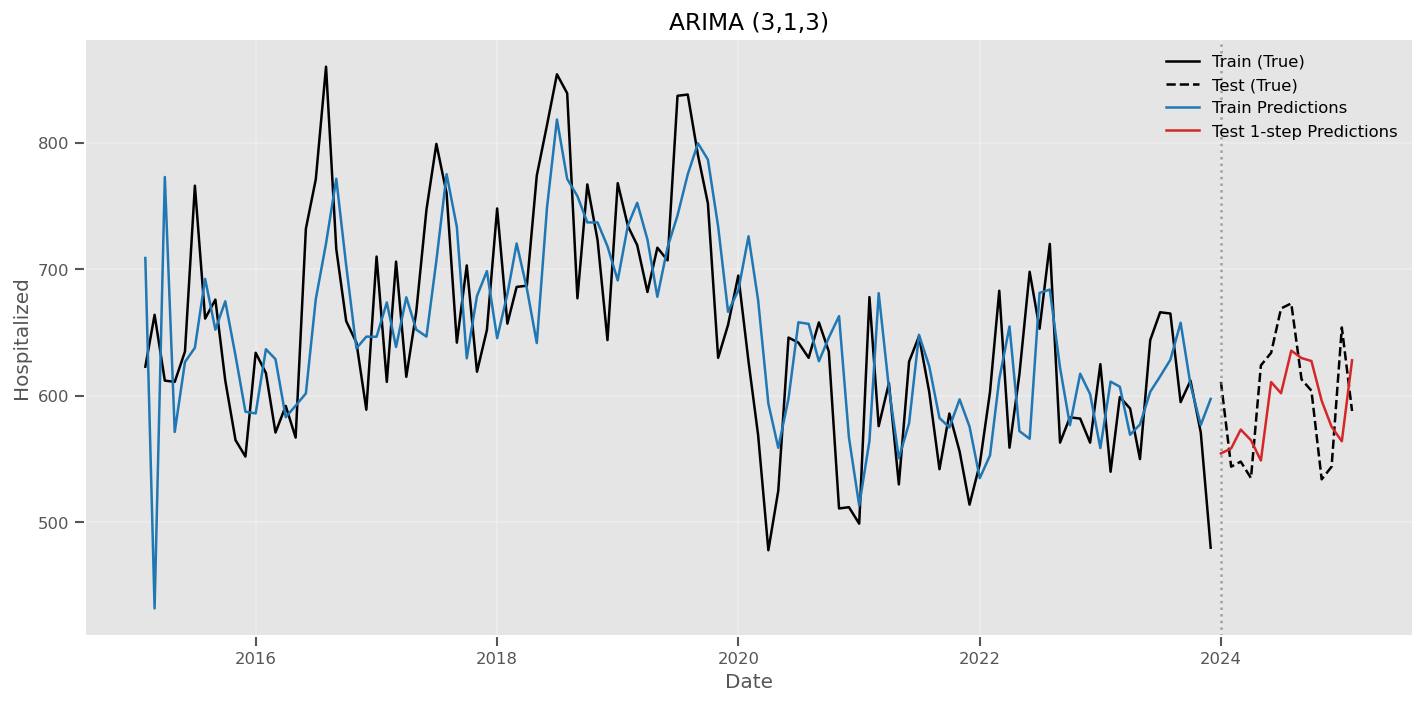

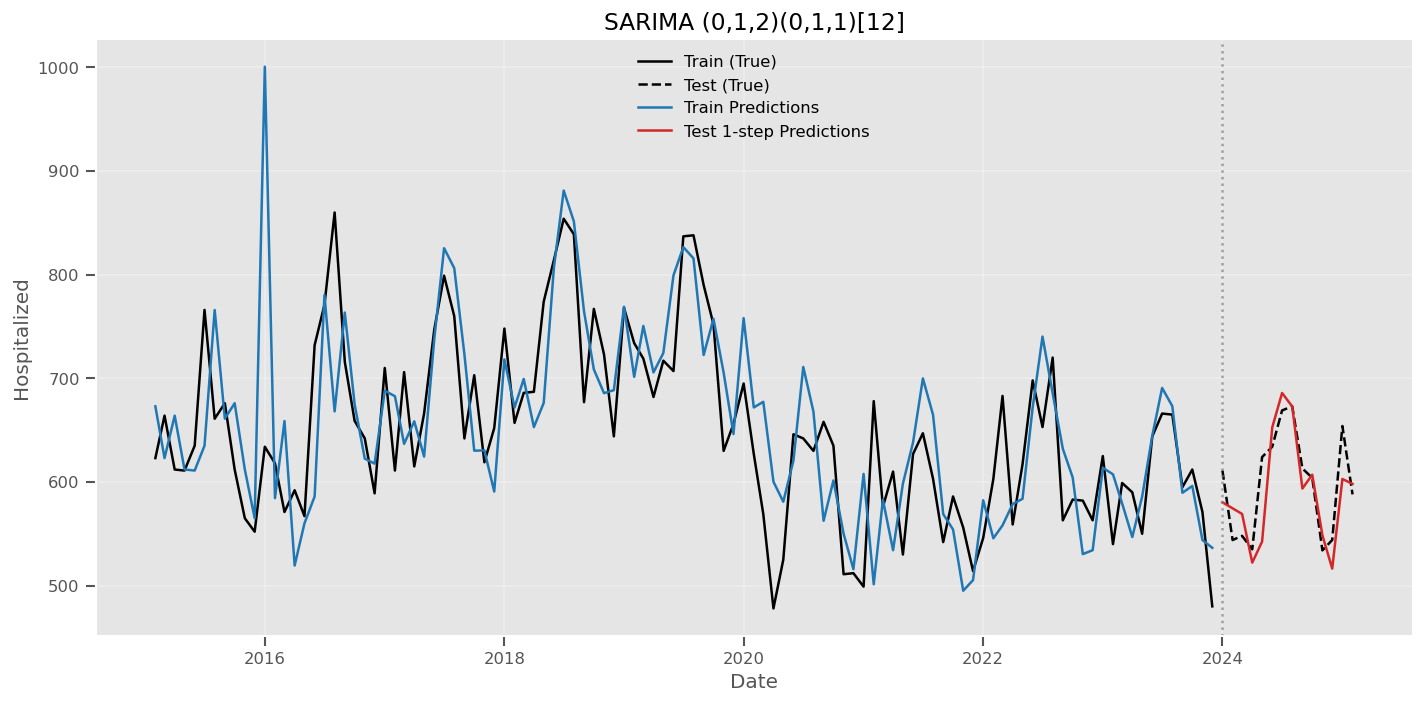

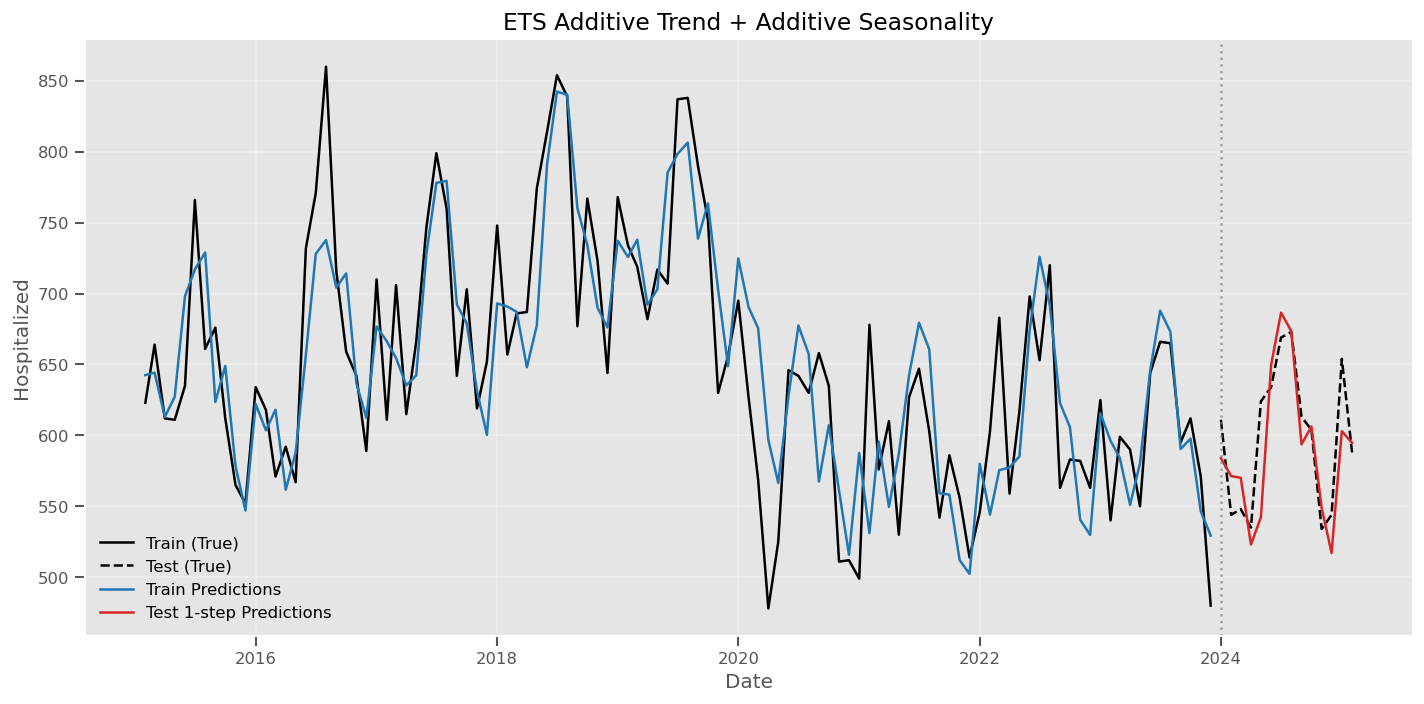

In [35]:
plot_forecast_results(results_arima, title="ARIMA (3,1,3)")
plot_forecast_results(results_sarima, title="SARIMA (0,1,2)(0,1,1)[12]")
plot_forecast_results(results_ets, title="ETS Additive Trend + Additive Seasonality")


In [36]:

def fit_evaluate_sarima_multistep(
    y: pd.Series,
    order: tuple[int, int, int] = (1, 0, 1),
    seasonal_order: tuple[int, int, int, int] = (1, 1, 1, 12),
    train_end: str = "2023-12-01",
) -> dict:
    """
    Fit a SARIMA model once on the training data and evaluate using the
    *default* multi-step recursive forecasting strategy.

    Parameters
    ----------
    y : pd.Series
        Full time series (train + test), monthly indexed.
    order : (p,d,q)
        Non-seasonal SARIMA order.
    seasonal_order : (P,D,Q,m)
        Seasonal SARIMA order.
    train_end : str
        Last timestamp of the training period.

    Returns
    -------
    results : dict
        {
          "model_name", "fit",
          "train_true", "train_pred",
          "test_true", "test_pred",
          "train_metrics", "test_metrics",
          "forecast_res"  # full statsmodels forecast object
        }
    """
    y = y.sort_index()

    # Train/test split
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]   # 2024 monthly

    # --- Fit SARIMA on train only ---
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fit = model.fit(disp=False)

    # --- In-sample predictions on train (1-step-ahead, non-rolling) ---
    train_pred = fit.get_prediction(dynamic=False).predicted_mean
    train_pred = train_pred.loc[y_train.index]  # align
    train_metrics = mae_rmse(y_train, train_pred)

    # --- Default SARIMA forecasting: multi-step recursive forecast on test horizon ---
    h = len(y_test)
    forecast_res = fit.get_forecast(steps=h)
    test_pred = forecast_res.predicted_mean

    # Align forecast index with actual test index (for safety)
    test_pred.index = y_test.index
    test_metrics = mae_rmse(y_test, test_pred)

    results = {
        "model_name": f"SARIMA{order}x{seasonal_order}_multistep",
        "fit": fit,
        "train_true": y_train,
        "train_pred": train_pred,
        "test_true": y_test,
        "test_pred": test_pred,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "forecast_res": forecast_res,  # for conf_int, etc.
    }
    return results


In [37]:
# y_hosp = monthly_global["Hospitalized"]

simple_sarima_results = fit_evaluate_sarima_multistep(
    y_hosp,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 12),
    train_end="2023-12-01",
)

print(simple_sarima_results["train_metrics"])
print(simple_sarima_results["test_metrics"])


{'MAE': np.float64(59.285905712969985), 'RMSE': np.float64(107.96064946005)}
{'MAE': np.float64(20.791063215692922), 'RMSE': np.float64(26.291973400574914)}


In [39]:
print(len(simple_sarima_results['train_true']))

108


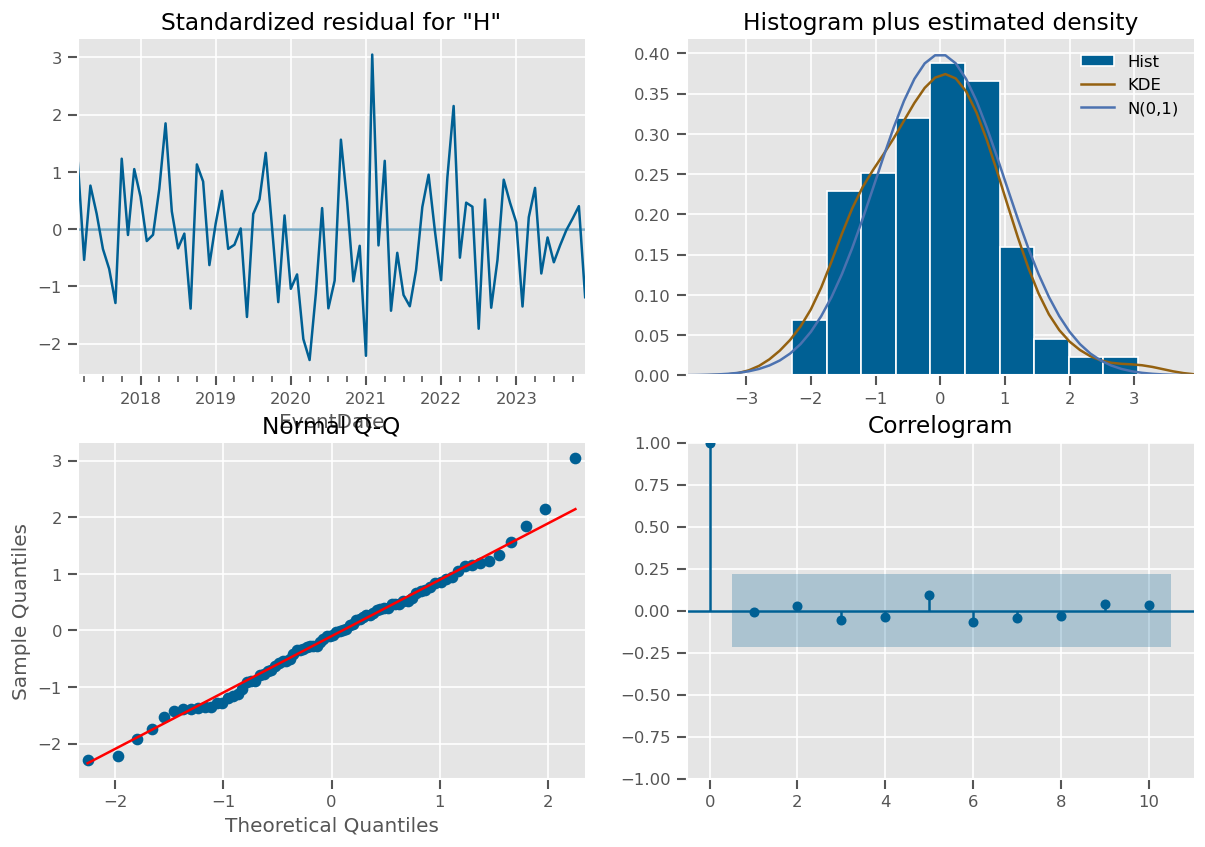

In [40]:
fit = simple_sarima_results["fit"]

resid = fit.resid                      # residuals
fig = fit.plot_diagnostics(figsize=(12, 8))  # built-in diagnostics

# Forecast intervals for 2024
fc_obj = simple_sarima_results["forecast_res"]
conf_int = fc_obj.conf_int()


In [41]:
from pathlib import Path


def results_to_df(results_list: list[dict]) -> pd.DataFrame:
    """
    Convert a list of model results dictionaries into a clean DataFrame.
    Expected keys: model_name, train_metrics, test_metrics.
    """
    rows = []
    for res in results_list:
        row = {
            "model": res["model_name"],
            "train_MAE": res["train_metrics"]["MAE"],
            "train_RMSE": res["train_metrics"]["RMSE"],
            "test_MAE": res["test_metrics"]["MAE"],
            "test_RMSE": res["test_metrics"]["RMSE"],
        }
        rows.append(row)

    return pd.DataFrame(rows)


In [51]:
def save_results_csv(
    df: pd.DataFrame,
    save_dir: Path,
    filename: str = "results.csv"
):
    """
    Save the evaluation results to a user-specified directory with a custom CSV filename.

    Parameters
    ----------
    df : pd.DataFrame
        Results table to save.
    save_dir : Path
        Directory where the file should be saved.
    filename : str
        Name of the CSV file (e.g., "sarima_results.csv").
    """

    # Ensure directory exists
    save_dir.mkdir(parents=True, exist_ok=True)

    # Construct file path
    out_path = save_dir / filename

    # Save
    df.to_csv(out_path, index=False)

    print(f"Saved results to: {out_path}")



In [43]:
all_results = [
    results_ets,
    results_arima,
    results_sarima,
    simple_sarima_results
]


In [44]:
from src.config import RESULTS_DIR

In [45]:
df_results = results_to_df(all_results)
save_results_csv(df_results, RESULTS_DIR)


Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\results.csv


## Amputation

In [46]:
y_amp = monthly_global["Amputation"]

In [47]:
results_ets_a = fit_evaluate_ets(y_amp, train_end="2023-12-01")

results_arima_a = fit_evaluate_arima(
    y_amp,
    order=(3, 1, 3),
    train_end="2023-12-01",
)

results_sarima_a = fit_evaluate_sarima(
    y_amp,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    train_end="2023-12-01",
)

# Example: inspect metrics
print("ETS train:", results_ets_a["train_metrics"], "test:", results_ets_a["test_metrics"])
print("ARIMA train:", results_arima_a["train_metrics"], "test:", results_arima_a["test_metrics"])
print("SARIMA train:", results_sarima_a["train_metrics"], "test:", results_sarima_a["test_metrics"])

ETS train: {'MAE': np.float64(15.269712754167587), 'RMSE': np.float64(19.49452918733021)} test: {'MAE': np.float64(16.899536729437877), 'RMSE': np.float64(20.062606278656112)}
ARIMA train: {'MAE': np.float64(22.865575514383277), 'RMSE': np.float64(36.40733053946602)} test: {'MAE': np.float64(18.355068282477923), 'RMSE': np.float64(20.696324008551944)}
SARIMA train: {'MAE': np.float64(23.17510529741806), 'RMSE': np.float64(36.48032902061422)} test: {'MAE': np.float64(19.92185681923012), 'RMSE': np.float64(24.241098089694948)}


In [48]:
simple_sarima_results_a = fit_evaluate_sarima_multistep(
    y_amp,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 12),
    train_end="2023-12-01",
)

print(simple_sarima_results_a["train_metrics"])
print(simple_sarima_results_a["test_metrics"])

{'MAE': np.float64(26.32216900512679), 'RMSE': np.float64(40.36441038867946)}
{'MAE': np.float64(22.664088555806643), 'RMSE': np.float64(28.792192409645313)}


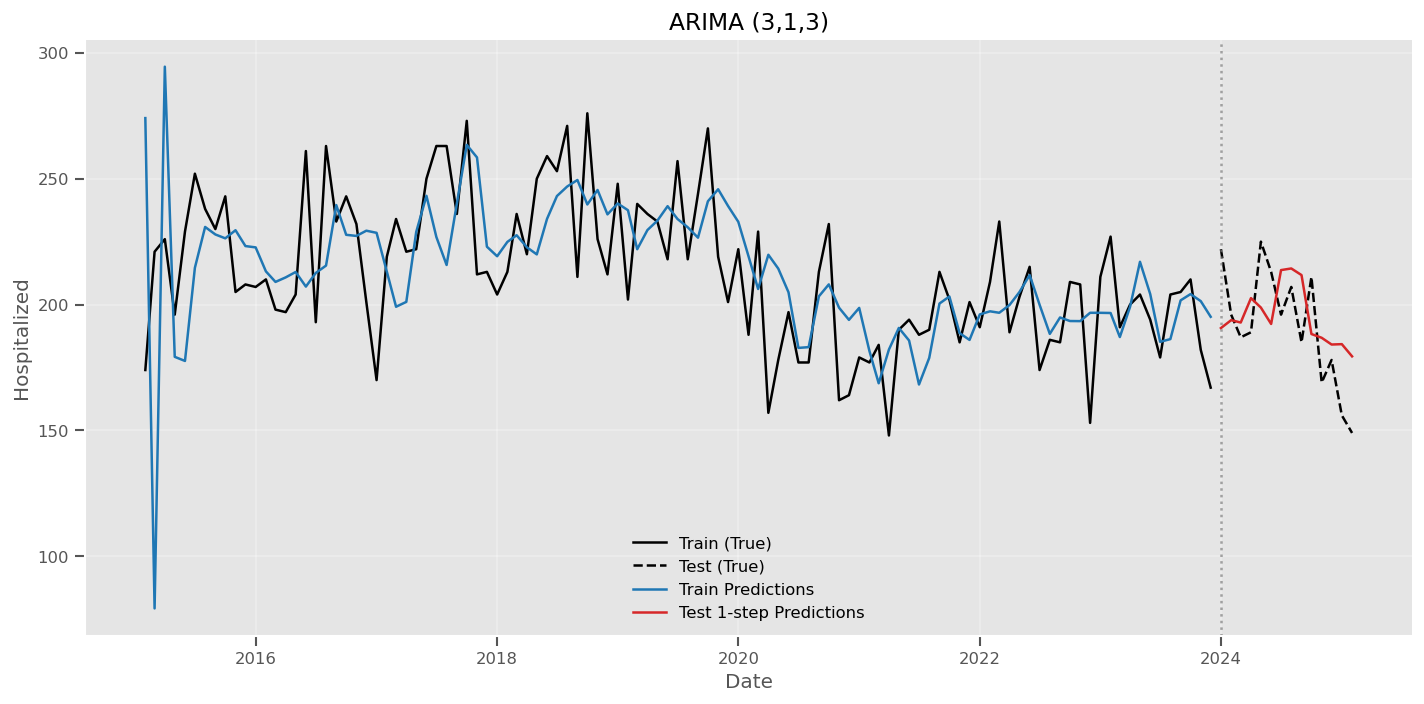

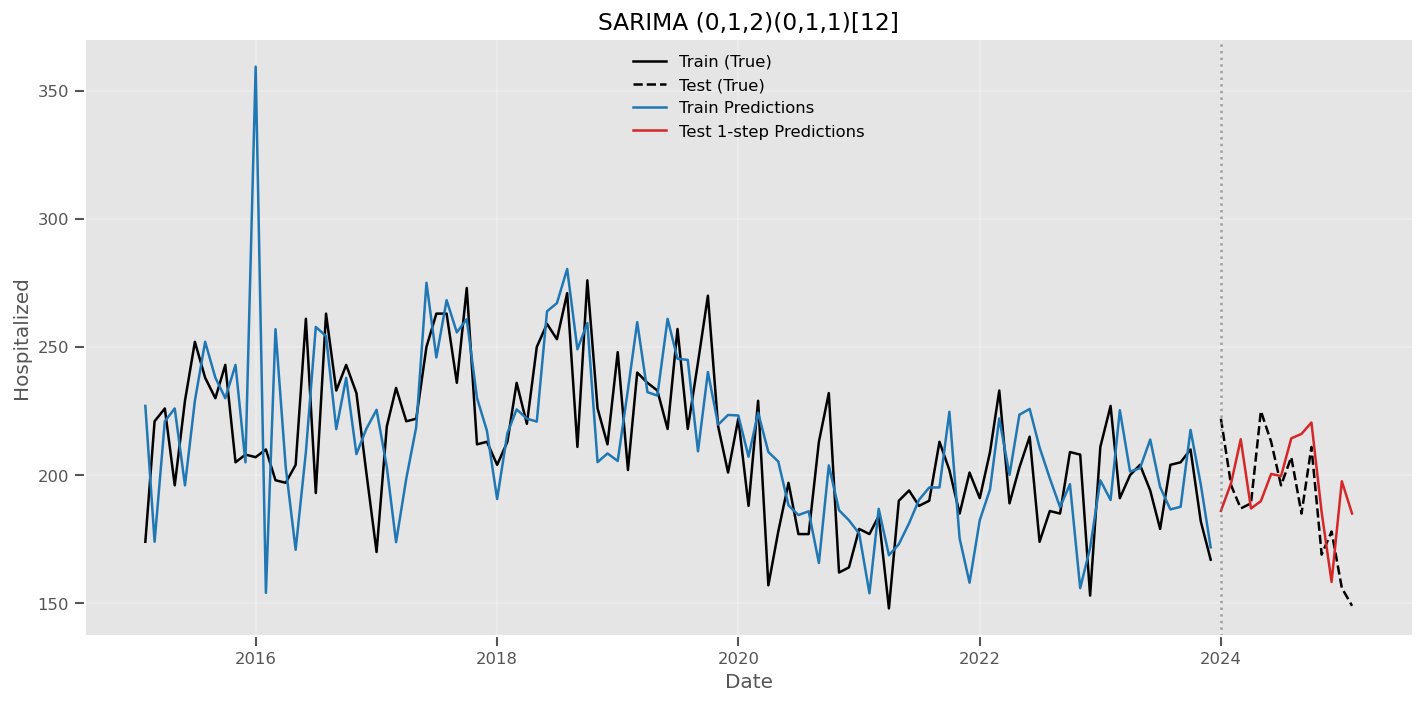

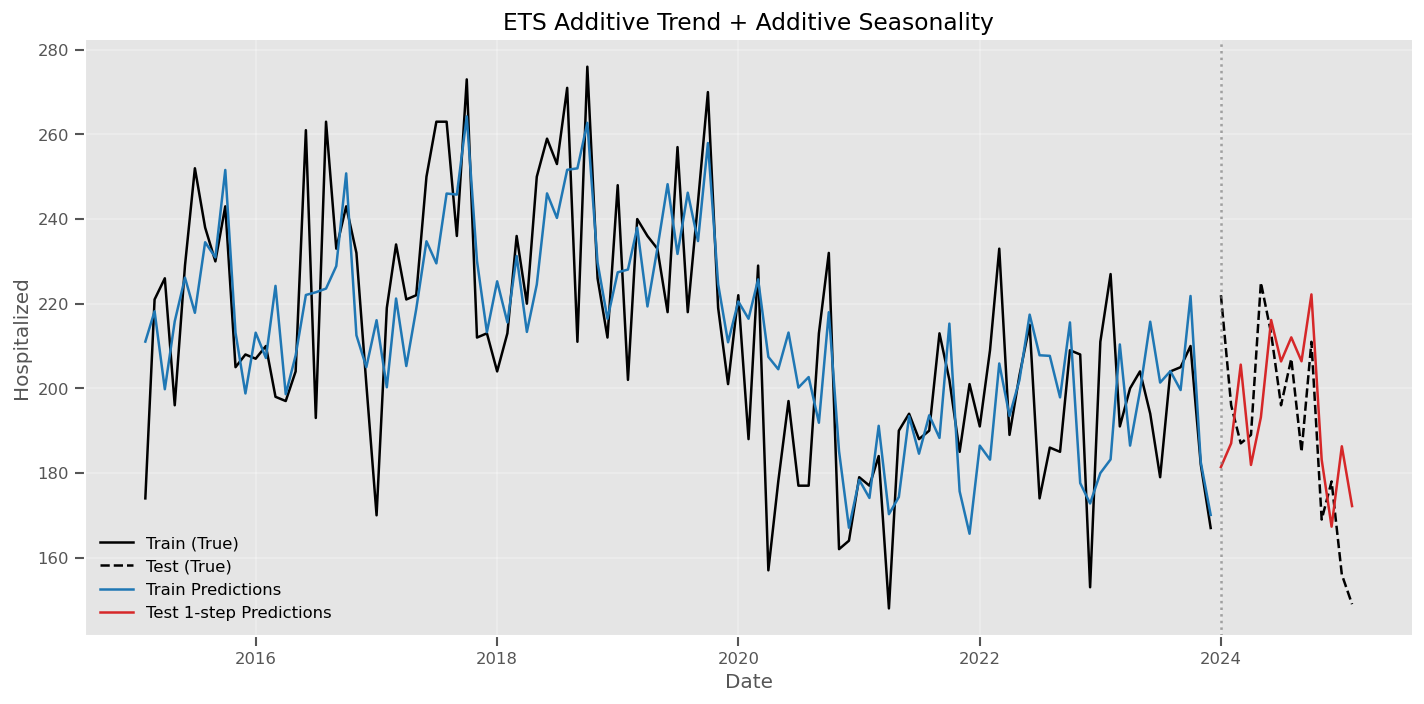

In [49]:
plot_forecast_results(results_arima_a, title="ARIMA (3,1,3)")
plot_forecast_results(results_sarima_a, title="SARIMA (0,1,2)(0,1,1)[12]")
plot_forecast_results(results_ets_a, title="ETS Additive Trend + Additive Seasonality")

In [50]:
all_results_a = [
    results_ets_a,
    results_arima_a,
    results_sarima_a,
    simple_sarima_results_a
]

In [52]:
df_results_a = results_to_df(all_results_a)
save_results_csv(df_results_a, save_dir=RESULTS_DIR / "national", filename='amputation.csv')

Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\amputation.csv


## ML models / linear: Ridge, Lasso, ElasticNet, PLS
### Hospitalization

In [53]:
from __future__ import annotations

import numpy as np
import pandas as pd
from typing import Iterable, Optional, Dict


def build_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Build calendar/seasonal features from a DatetimeIndex.
    """
    cal = pd.DataFrame(index=idx)
    cal["year"] = idx.year
    cal["month"] = idx.month
    cal["quarter"] = idx.quarter

    # cyclical encoding for month
    cal["month_sin"] = np.sin(2 * np.pi * cal["month"] / 12)
    cal["month_cos"] = np.cos(2 * np.pi * cal["month"] / 12)

    return cal


def build_feature_matrix(
    y: pd.Series,
    *,
    # AR features
    lags: Iterable[int] = (1, 2, 3, 6, 12),
    rolling_windows: Iterable[int] = (3, 6, 12),
    ewma_spans: Iterable[int] = (3, 6, 12),
    add_calendar: bool = True,
    # Exogenous features
    exog_df: Optional[pd.DataFrame] = None,
    exog_cols: Optional[Iterable[str]] = None,
    exog_lag_config: Optional[Dict[str, Iterable[int]]] = None,
) -> tuple[pd.DataFrame, pd.Series]:
    """
    Build a flexible feature matrix for ML models from a univariate target series.

    Features:
    - Calendar / seasonal features (optional)
    - Lagged values of y
    - Rolling means of y (using only past data)
    - EWMAs of y (using only past data)
    - Selected exogenous features (exog_cols) from exog_df
    - Optional lagged exogenous features as specified in exog_lag_config

    Parameters
    ----------
    y : pd.Series
        Target time series with DatetimeIndex and fixed monthly frequency.
    lags : iterable of int
        Lags of y to include (e.g. [1,2,3,6,12]).
    rolling_windows : iterable of int
        Window sizes for rolling means of y.
    ewma_spans : iterable of int
        Spans for EWMA of y.
    add_calendar : bool
        If True, add calendar / seasonal features.
    exog_df : pd.DataFrame, optional
        DataFrame with exogenous features, indexed by the same DatetimeIndex as y.
        This can contain things like NAICS counts, encoded states, event types, etc.
    exog_cols : iterable of str, optional
        Names of columns in exog_df to include as contemporaneous features.
        (We assume these have been constructed in a leakage-safe way.)
    exog_lag_config : dict, optional
        Mapping from exogenous column name -> iterable of lags to create.
        Example: {"naics_top5_share": [1, 12], "state_te": [1, 2, 3]}

    Returns
    -------
    X : pd.DataFrame
        Feature matrix.
    y_supervised : pd.Series
        Target aligned with X after dropping rows with NaNs.
    """
    y = y.sort_index()
    df = pd.DataFrame({"y": y})

    # -----------------------
    # AR lag features (y)
    # -----------------------
    for lag in lags:
        df[f"lag_{lag}"] = df["y"].shift(lag)

    # -----------------------
    # Rolling means (no leakage: use shifted y)
    # -----------------------
    y_shifted = df["y"].shift(1)
    for w in rolling_windows:
        df[f"rollmean_{w}"] = y_shifted.rolling(window=w, min_periods=w).mean()

    # -----------------------
    # EWMA features (no leakage: use shifted y)
    # -----------------------
    for span in ewma_spans:
        df[f"ewma_{span}"] = y_shifted.ewm(span=span, adjust=False).mean()

    # -----------------------
    # Calendar / seasonal features
    # -----------------------
    if add_calendar:
        cal = build_calendar_features(df.index)
        df = df.join(cal)

    # -----------------------
    # Exogenous features (user-controlled)
    # -----------------------
    if exog_df is not None:
        # Make sure exog index aligns with y
        exog_df = exog_df.sort_index()
        exog_df = exog_df.reindex(df.index)

        # 1) contemporaneous exog cols
        if exog_cols is not None:
            exog_cols = list(exog_cols)
            df = df.join(exog_df[exog_cols])

        # 2) lagged exog features
        if exog_lag_config is not None:
            for col, lag_list in exog_lag_config.items():
                if col not in exog_df.columns:
                    raise ValueError(f"Column '{col}' not in exog_df.")
                for lag in lag_list:
                    df[f"{col}_lag_{lag}"] = exog_df[col].shift(lag)

    # -----------------------
    # Drop rows with missing values after all transformations
    # -----------------------
    df_clean = df.dropna()

    y_supervised = df_clean["y"].copy()
    X = df_clean.drop(columns=["y"])

    return X, y_supervised


In [54]:
X_hosp, y_hosp_sup = build_feature_matrix(
    y_hosp,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewma_spans=(3, 6, 12),
    add_calendar=True,
)


In [55]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression

from typing import Dict, Any


In [56]:
def fit_evaluate_linear_models(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> Dict[str, Dict[str, Any]]:
    """
    Fit and evaluate a family of linear models on the same train/test split.

    Models:
    - Ridge
    - Lasso
    - Elastic Net
    - PLSRegression

    Returns
    -------
    results : dict
        Keys are model names, values are dicts with:
        - model_name
        - estimator      (fitted sklearn Pipeline or estimator)
        - train_true
        - train_pred
        - test_true
        - test_pred
        - train_metrics
        - test_metrics
    """
    results: Dict[str, Dict[str, Any]] = {}

    # Ensure alignment and convert y to 1D array for sklearn
    y_train_arr = np.asarray(y_train)
    y_test_arr = np.asarray(y_test)

    # -----------------------
    # 1. Ridge
    # -----------------------
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0, random_state=0)),
    ])
    ridge_pipe.fit(X_train, y_train_arr)

    ridge_train_pred = pd.Series(
        ridge_pipe.predict(X_train), index=y_train.index, name="Ridge_train_pred"
    )
    ridge_test_pred = pd.Series(
        ridge_pipe.predict(X_test), index=y_test.index, name="Ridge_test_pred"
    )

    results["Ridge"] = {
        "model_name": "Ridge",
        "estimator": ridge_pipe,
        "train_true": y_train,
        "train_pred": ridge_train_pred,
        "test_true": y_test,
        "test_pred": ridge_test_pred,
        "train_metrics": mae_rmse(y_train, ridge_train_pred),
        "test_metrics": mae_rmse(y_test, ridge_test_pred),
    }

    # -----------------------
    # 2. Lasso
    # -----------------------
    lasso_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(alpha=0.01, random_state=0, max_iter=10000)),
    ])
    lasso_pipe.fit(X_train, y_train_arr)

    lasso_train_pred = pd.Series(
        lasso_pipe.predict(X_train), index=y_train.index, name="Lasso_train_pred"
    )
    lasso_test_pred = pd.Series(
        lasso_pipe.predict(X_test), index=y_test.index, name="Lasso_test_pred"
    )

    results["Lasso"] = {
        "model_name": "Lasso",
        "estimator": lasso_pipe,
        "train_true": y_train,
        "train_pred": lasso_train_pred,
        "test_true": y_test,
        "test_pred": lasso_test_pred,
        "train_metrics": mae_rmse(y_train, lasso_train_pred),
        "test_metrics": mae_rmse(y_test, lasso_test_pred),
    }

    # -----------------------
    # 3. Elastic Net
    # -----------------------
    enet_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=0, max_iter=10000)),
    ])
    enet_pipe.fit(X_train, y_train_arr)

    enet_train_pred = pd.Series(
        enet_pipe.predict(X_train), index=y_train.index, name="ElasticNet_train_pred"
    )
    enet_test_pred = pd.Series(
        enet_pipe.predict(X_test), index=y_test.index, name="ElasticNet_test_pred"
    )

    results["ElasticNet"] = {
        "model_name": "ElasticNet",
        "estimator": enet_pipe,
        "train_true": y_train,
        "train_pred": enet_train_pred,
        "test_true": y_test,
        "test_pred": enet_test_pred,
        "train_metrics": mae_rmse(y_train, enet_train_pred),
        "test_metrics": mae_rmse(y_test, enet_test_pred),
    }

    # -----------------------
    # 4. PLSRegression
    # -----------------------
    # choose number of components (can tune later)
    n_components = min(10, X_train.shape[1], X_train.shape[0] - 1)

    pls = Pipeline([
        ("scaler", StandardScaler()),
        ("model", PLSRegression(n_components=n_components)),
    ])
    pls.fit(X_train, y_train_arr)

    pls_train_pred = pd.Series(
        pls.predict(X_train).ravel(), index=y_train.index, name="PLS_train_pred"
    )
    pls_test_pred = pd.Series(
        pls.predict(X_test).ravel(), index=y_test.index, name="PLS_test_pred"
    )

    results["PLS"] = {
        "model_name": f"PLS(n_components={n_components})",
        "estimator": pls,
        "train_true": y_train,
        "train_pred": pls_train_pred,
        "test_true": y_test,
        "test_pred": pls_test_pred,
        "train_metrics": mae_rmse(y_train, pls_train_pred),
        "test_metrics": mae_rmse(y_test, pls_test_pred),
    }

    return results


In [121]:
train_end = "2023-12-01"

X_train = X_hosp.loc[:train_end]
y_train = y_hosp_sup.loc[:train_end]

X_test = X_hosp.loc[train_end:]
y_test = y_hosp_sup.loc[train_end:]

In [122]:
linear_results = fit_evaluate_linear_models(X_train, y_train, X_test, y_test)


In [123]:
print(linear_results["Ridge"]["test_metrics"], linear_results["Lasso"]["test_metrics"], linear_results["ElasticNet"]["test_metrics"], linear_results["PLS"]["test_metrics"])


{'MAE': np.float64(28.244327749997925), 'RMSE': np.float64(36.98504274937136)} {'MAE': np.float64(26.53780738785595), 'RMSE': np.float64(35.45079541998132)} {'MAE': np.float64(27.3378212109025), 'RMSE': np.float64(36.17915345674004)} {'MAE': np.float64(26.949236015584997), 'RMSE': np.float64(35.48195677355289)}


In [61]:
from pathlib import Path

all_linear_results = list(linear_results.values())
df_linear = results_to_df(all_linear_results)
save_results_csv(df_linear, save_dir=RESULTS_DIR / "national", filename="linear_models_hosp.csv")


Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\linear_models_hosp.csv


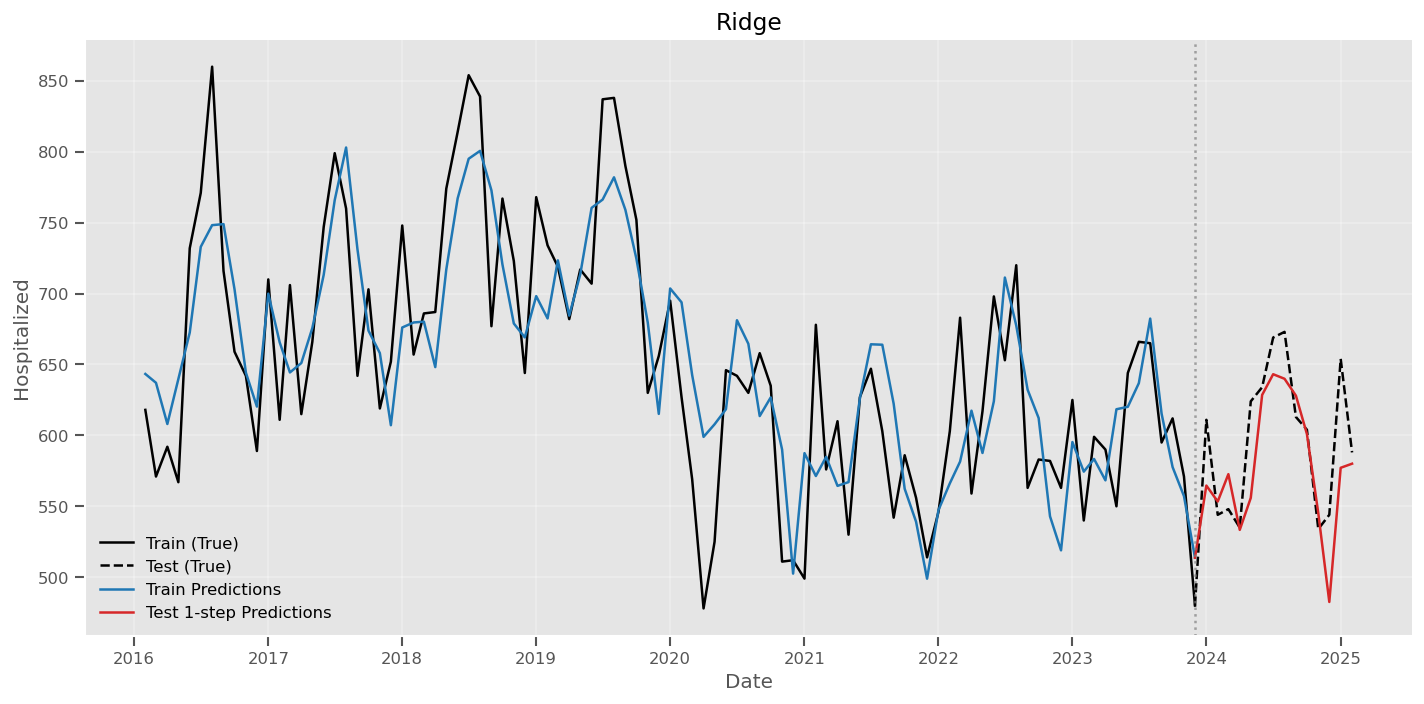

In [62]:
plot_forecast_results(linear_results["Ridge"])

## Tree-based ensemble models: XGBoost, LightGBM, CatBoost

In [63]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [64]:
def fit_evaluate_boosting_models(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> Dict[str, Dict[str, Any]]:
    """
    Fit and evaluate boosting-based tree models:
    - XGBoost
    - LightGBM
    - CatBoost

    Uses simple, stable defaults. Returns results dicts that match the structure
    used for classical and linear models.
    """

    results: Dict[str, Dict[str, Any]] = {}

    y_train_arr = y_train.values
    y_test_arr = y_test.values

    # -----------------------
    # 1. XGBoost
    # -----------------------
    if XGBRegressor is not None:
        xgb = XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=0,
            n_jobs=-1,
        )
        xgb.fit(X_train, y_train_arr)

        xgb_train_pred = pd.Series(xgb.predict(X_train), index=y_train.index)
        xgb_test_pred = pd.Series(xgb.predict(X_test), index=y_test.index)

        results["XGBoost"] = {
            "model_name": "XGBoost",
            "estimator": xgb,
            "train_true": y_train,
            "train_pred": xgb_train_pred,
            "test_true": y_test,
            "test_pred": xgb_test_pred,
            "train_metrics": mae_rmse(y_train, xgb_train_pred),
            "test_metrics": mae_rmse(y_test, xgb_test_pred),
        }

    # -----------------------
    # 2. LightGBM
    # -----------------------
    if LGBMRegressor is not None:
        lgbm = LGBMRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="regression",
            random_state=0,
            n_jobs=-1,
        )
        lgbm.fit(X_train, y_train_arr)

        lgbm_train_pred = pd.Series(lgbm.predict(X_train), index=y_train.index)
        lgbm_test_pred = pd.Series(lgbm.predict(X_test), index=y_test.index)

        results["LightGBM"] = {
            "model_name": "LightGBM",
            "estimator": lgbm,
            "train_true": y_train,
            "train_pred": lgbm_train_pred,
            "test_true": y_test,
            "test_pred": lgbm_test_pred,
            "train_metrics": mae_rmse(y_train, lgbm_train_pred),
            "test_metrics": mae_rmse(y_test, lgbm_test_pred),
        }

    # -----------------------
    # 3. CatBoost
    # -----------------------
    if CatBoostRegressor is not None:
        cb = CatBoostRegressor(
            iterations=400,
            learning_rate=0.05,
            depth=4,
            loss_function="RMSE",
            random_state=0,
            verbose=False,
        )
        cb.fit(X_train, y_train_arr)

        cb_train_pred = pd.Series(cb.predict(X_train), index=y_train.index)
        cb_test_pred = pd.Series(cb.predict(X_test), index=y_test.index)

        results["CatBoost"] = {
            "model_name": "CatBoost",
            "estimator": cb,
            "train_true": y_train,
            "train_pred": cb_train_pred,
            "test_true": y_test,
            "test_pred": cb_test_pred,
            "train_metrics": mae_rmse(y_train, cb_train_pred),
            "test_metrics": mae_rmse(y_test, cb_test_pred),
        }

    return results


In [65]:
X_hosp, y_hosp_sup = build_feature_matrix(
    y_hosp,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewma_spans=(3, 6, 12),
    add_calendar=True,
    # exog_df=..., exog_cols=..., exog_lag_config=...
)

train_end = "2023-12-01"
X_train = X_hosp.loc[:train_end]
y_train = y_hosp_sup.loc[:train_end]
X_test = X_hosp.loc[train_end:]
y_test = y_hosp_sup.loc[train_end:]


In [66]:
tree_results = fit_evaluate_boosting_models(X_train, y_train, X_test, y_test)


In [67]:
df_tree_h = results_to_df(list(tree_results.values()))
save_results_csv(df_tree_h, save_dir=RESULTS_DIR / "national", filename="tree_models_hosp.csv")


Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\tree_models_hosp.csv


In [68]:


def get_single_model_importance(
    estimator,
    feature_names: list[str],
    model_name: str,
    importance_type: str = "default",
) -> pd.Series:
    """
    Extract feature importance from a tree/boosting estimator and
    return it as a sorted pandas Series.

    Supports:
    - XGBoost, LightGBM: estimator.feature_importances_
    - CatBoost: estimator.get_feature_importance()

    Parameters
    ----------
    estimator : fitted model
    feature_names : list of feature names (X_train.columns)
    model_name : label, only used for error messages
    importance_type : str
        For CatBoost, you could select different importance types later.
        For now we keep it as a placeholder.

    Returns
    -------
    importance : pd.Series
        Index = feature names, values = importance scores, sorted desc.
    """
    importances = None

    # XGBoost & LightGBM style
    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_

    # CatBoost style
    elif hasattr(estimator, "get_feature_importance"):
        # importance_type is not used here but can be plugged into CatBoost API
        importances = estimator.get_feature_importance()

    else:
        raise ValueError(f"Estimator for {model_name} does not expose feature importances.")

    importance_series = pd.Series(importances, index=feature_names, name=model_name)
    importance_series = importance_series.sort_values(ascending=False)

    return importance_series


In [69]:
def get_boosting_feature_importances(
    boost_results: dict,
    X_train: pd.DataFrame,
) -> dict[str, pd.Series]:
    """
    Compute feature importances for all boosting models
    (XGBoost, LightGBM, CatBoost) contained in boost_results.

    Parameters
    ----------
    boost_results : dict
        Output of fit_evaluate_boosting_models.
    X_train : pd.DataFrame
        Training feature matrix. Column names are used as feature names.

    Returns
    -------
    importances_dict : dict
        Keys = model keys ("XGBoost", "LightGBM", "CatBoost")
        Values = pd.Series with sorted feature importances.
    """
    feature_names = list(X_train.columns)
    importances_dict: dict[str, pd.Series] = {}

    for key, res in boost_results.items():
        est = res["estimator"]
        model_name = res["model_name"]

        importance_series = get_single_model_importance(
            estimator=est,
            feature_names=feature_names,
            model_name=model_name,
        )
        importances_dict[key] = importance_series

    return importances_dict


In [70]:
def get_boosting_feature_importances(
    boost_results: dict,
    X_train: pd.DataFrame,
) -> dict[str, pd.Series]:
    """
    Compute feature importances for all boosting models
    (XGBoost, LightGBM, CatBoost) contained in boost_results.

    Parameters
    ----------
    boost_results : dict
        Output of fit_evaluate_boosting_models.
    X_train : pd.DataFrame
        Training feature matrix. Column names are used as feature names.

    Returns
    -------
    importances_dict : dict
        Keys = model keys ("XGBoost", "LightGBM", "CatBoost")
        Values = pd.Series with sorted feature importances.
    """
    feature_names = list(X_train.columns)
    importances_dict: dict[str, pd.Series] = {}

    for key, res in boost_results.items():
        est = res["estimator"]
        model_name = res["model_name"]

        importance_series = get_single_model_importance(
            estimator=est,
            feature_names=feature_names,
            model_name=model_name,
        )
        importances_dict[key] = importance_series

    return importances_dict


In [71]:
importances = get_boosting_feature_importances(tree_results, X_train)

In [75]:
feat_imp_df = pd.concat(
    {model: s for model, s in importances.items()},
    axis=1
)

feat_imp_df


,XGBoost,LightGBM,CatBoost
year,0.284282,141,10.417792
ewma_3,0.179532,62,10.742823
month_cos,0.122660,93,7.407983
rollmean_3,0.066457,31,4.887883
lag_12,0.062771,146,10.359535
ewma_6,0.056968,50,3.616260
month,0.044868,134,16.323714
lag_1,0.033117,85,6.503194
month_sin,0.030460,59,7.173504
rollmean_12,0.028422,12,3.515907


In [78]:
def stack_importances(importances: dict[str, pd.Series]) -> pd.DataFrame:
    """
    Convert dict of importance Series into a matrix:
    rows = features
    columns = models
    """
    df = pd.concat(importances, axis=1)  # columns = MultiIndex (model, feature)
    #df.columns = df.columns.droplevel(0)  # flatten to just model names
    return df


In [79]:
imp_matrix = stack_importances(importances)


In [80]:
imp_matrix

,XGBoost,LightGBM,CatBoost
year,0.284282,141,10.417792
ewma_3,0.179532,62,10.742823
month_cos,0.122660,93,7.407983
rollmean_3,0.066457,31,4.887883
lag_12,0.062771,146,10.359535
ewma_6,0.056968,50,3.616260
month,0.044868,134,16.323714
lag_1,0.033117,85,6.503194
month_sin,0.030460,59,7.173504
rollmean_12,0.028422,12,3.515907


In [81]:
imp_norm = imp_matrix.divide(imp_matrix.sum(axis=0), axis=1)


In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_importance_heatmap(imp_norm: pd.DataFrame, top_n: int = 25):
    """
    Plot a heatmap for the top N most important features
    across all boosting models.
    """

    # Select top features by mean importance across models
    top_features = imp_norm.mean(axis=1).sort_values(ascending=False).head(top_n).index
    imp_top = imp_norm.loc[top_features]

    plt.figure(figsize=(10, max(6, top_n * 0.3)))  # dynamic height
    sns.heatmap(
        imp_top,
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Normalized Importance"},
    )
    plt.title("Feature Importance Heatmap Across Boosting Models")
    plt.xlabel("Model")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


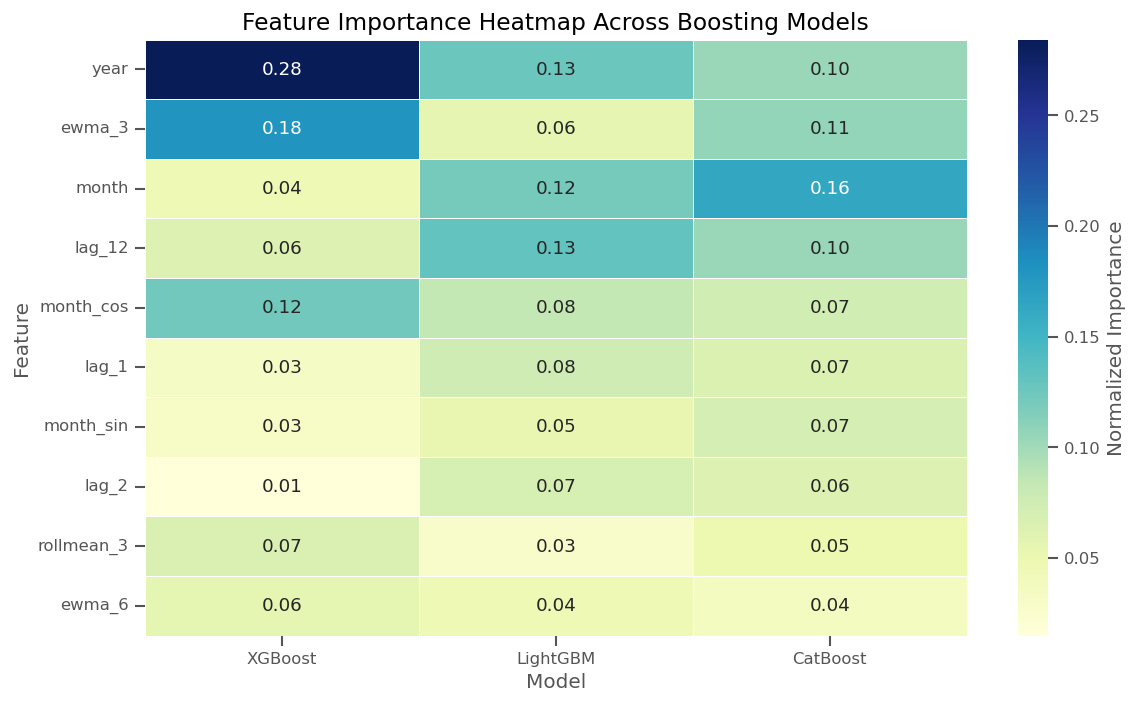

In [83]:
plot_importance_heatmap(imp_norm, top_n=10)

## Weekly

In [84]:
def aggregate_time_series(
    df: pd.DataFrame,
    date_col: str = "EventDate",
    target_cols: list[str] = ["Hospitalized", "Amputation"],
    freq: str = "MS",     # "MS" monthly, "W-MON" weekly, "Q" quarterly, etc.
    agg: str = "sum",
) -> pd.DataFrame:
    """
    Aggregate incident-level data into a time series of arbitrary frequency.

    Parameters
    ----------
    df : pd.DataFrame
        Original event-level dataframe.
    date_col : str
        Name of the timestamp column.
    target_cols : list of str
        Columns to aggregate (e.g. ["Hospitalized", "Amputation"]).
    freq : str
        Target resampling frequency. Examples:
            "MS"     → Month Start
            "M"      → Month End
            "W-MON"  → Weekly (Mondays)
            "W"      → Weekly (Sundays)
            "Q"      → Quarterly
            "A"      → Annual
    agg : str
        Aggregation function applied to the period ("sum", "mean", "max", ...).

    Returns
    -------
    ts_df : pd.DataFrame
        Aggregated time series indexed with the desired frequency.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # 1) Aggregate to daily first (handles multiple events per day)
    daily = (
        df.groupby(date_col)[target_cols]
          .agg(agg)
          .sort_index()
    )

    # 2) Resample to chosen frequency
    ts_df = daily.resample(freq).agg(agg)

    # 3) Ensure frequency is explicitly set
    ts_df = ts_df.asfreq(freq)

    return ts_df


In [85]:
ts_weekly = aggregate_time_series(df, freq="W-MON")


In [87]:
ts_weekly.head()
y_hosp_wk = ts_weekly['Hospitalized']
y_hosp_wk

EventDate
2015-01-05     66
2015-01-12    171
2015-01-19    148
2015-01-26    162
2015-02-02    160
             ... 
2025-02-03    138
2025-02-10    133
2025-02-17    164
2025-02-24    142
2025-03-03    108
Freq: W-MON, Name: Hospitalized, Length: 531, dtype: int64

In [91]:


# (Optional) restrict to pre-2024 data for order selection:
y_hosp_train_wk = y_hosp_wk.loc[: "2023-12-01"]

# 2. ARIMA order search (non-seasonal)
arima_results, best_arima_order = find_best_arima(
    y=y_hosp_train_wk,
    ic="aic",
)

print("Best ARIMA order:", best_arima_order)
print(arima_results.head())



Best ARIMA order: (2, 1, 3)
       order seasonal_order          aic          bic
0  (2, 1, 3)           None  4112.596795  4137.384154
1  (3, 1, 3)           None  4114.564965  4143.483550
2  (0, 1, 3)           None  4115.133978  4131.658884
3  (0, 2, 3)           None  4115.839271  4132.355472
4  (1, 1, 3)           None  4117.093127  4137.749259


In [93]:


simple_sarima_results_wk = fit_evaluate_sarima_multistep(
    y_hosp_wk,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52),
    train_end="2023-12-01",
)

print(simple_sarima_results_wk["train_metrics"])
print(simple_sarima_results_wk["test_metrics"])

{'MAE': np.float64(16.54208300781697), 'RMSE': np.float64(21.594901535619947)}
{'MAE': np.float64(14.892802935619978), 'RMSE': np.float64(19.44548545281116)}


In [95]:

def fit_evaluate_ets_multistep(
    y: pd.Series,
    train_end: str,
    trend: str | None = "add",
    seasonal: str | None = "add",
    seasonal_periods: int | None = None,
) -> dict:
    """
    Fit an ETS model once on the training data and evaluate using
    default multi-step forecasting for the test horizon.

    Parameters
    ----------
    y : pd.Series
        Full time series (train + test).
    train_end : str
        Last timestamp of the training period (e.g. "2023-12-31").
    trend : {"add", "mul", None}
    seasonal : {"add", "mul", None}
    seasonal_periods : int or None
        e.g. 12 for monthly, 52 for weekly with yearly seasonality.

    Returns
    -------
    results : dict
        Same structure as for other models.
    """
    y = y.sort_index()
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]   # everything after train_end

    # Fit once on train
    ets_model = ExponentialSmoothing(
        y_train,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
    )
    ets_fit = ets_model.fit(optimized=True)

    # In-sample fitted values (train)
    train_pred = ets_fit.fittedvalues
    train_pred = train_pred.loc[y_train.index]
    train_metrics = mae_rmse(y_train, train_pred)

    # Multi-step forecast for test horizon
    h = len(y_test)
    test_fc = ets_fit.forecast(steps=h)
    test_fc.index = y_test.index
    test_metrics = mae_rmse(y_test, test_fc)

    return {
        "model_name": f"ETS(trend={trend}, seasonal={seasonal}, sp={seasonal_periods})",
        "fit": ets_fit,
        "train_true": y_train,
        "train_pred": train_pred,
        "test_true": y_test,
        "test_pred": test_fc,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
    }




In [96]:
results_ets_wk = fit_evaluate_ets_multistep(
    y_hosp_wk,                  # weekly aggregated series
    train_end="2023-12-31",
    trend="add",
    seasonal="add",
    seasonal_periods=52,
)

results_ets_wk


{'model_name': 'ETS(trend=add, seasonal=add, sp=52)',
 'fit': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x1fac4e71130>,
 'train_true': EventDate
 2015-01-05     66
 2015-01-12    171
 2015-01-19    148
 2015-01-26    162
 2015-02-02    160
              ... 
 2023-11-27     90
 2023-12-04    154
 2023-12-11    128
 2023-12-18    110
 2023-12-25     80
 Freq: W-MON, Name: Hospitalized, Length: 469, dtype: int64,
 'train_pred': EventDate
 2015-01-05     93.830475
 2015-01-12    127.521573
 2015-01-19    157.099996
 2015-01-26    155.005123
 2015-02-02    160.421540
                  ...    
 2023-11-27    117.673258
 2023-12-04    137.837636
 2023-12-11    143.939918
 2023-12-18    115.952423
 2023-12-25     79.544301
 Freq: W-MON, Length: 469, dtype: float64,
 'test_true': EventDate
 2024-01-08    114
 2024-01-15    115
 2024-01-22    187
 2024-01-29    139
 2024-02-05    121
              ... 
 2025-02-03    138
 2025-02-10    133
 2025-02-17    164
 2025-02-24 

In [97]:
import statsmodels.api as sm

def fit_evaluate_arima_multistep(
    y: pd.Series,
    order: tuple[int, int, int],
    train_end: str,
) -> dict:
    """
    Fit a non-seasonal ARIMA model once on the training data and
    evaluate using default multi-step forecasting for the test horizon.

    Parameters
    ----------
    y : pd.Series
        Full time series (train + test).
    order : (p, d, q)
        ARIMA order.
    train_end : str
        Last timestamp of the training period.

    Returns
    -------
    results : dict
        Same structure as other models.
    """
    y = y.sort_index()
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]

    # Fit ARIMA (as SARIMAX with no seasonal part) on train
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        order=order,
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fit = model.fit(disp=False)

    # In-sample predictions for train (1-step, no rolling refit)
    train_pred = fit.get_prediction(dynamic=False).predicted_mean
    train_pred = train_pred.loc[y_train.index]
    train_metrics = mae_rmse(y_train, train_pred)

    # Multi-step forecast for test horizon
    h = len(y_test)
    fc_res = fit.get_forecast(steps=h)
    test_fc = fc_res.predicted_mean
    test_fc.index = y_test.index
    test_metrics = mae_rmse(y_test, test_fc)

    return {
        "model_name": f"ARIMA{order}_multistep",
        "fit": fit,
        "train_true": y_train,
        "train_pred": train_pred,
        "test_true": y_test,
        "test_pred": test_fc,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "forecast_res": fc_res,  # for conf_int if needed
    }


In [125]:
results_arima_wk = fit_evaluate_arima_multistep(
    y_hosp_wk,
    order=(2, 1, 3),          # placeholder; you’ll select after order search
    train_end="2023-12-31",
)

results_arima_wk

{'model_name': 'ARIMA(2, 1, 3)_multistep',
 'fit': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1fa82765d30>,
 'train_true': EventDate
 2015-01-05     66
 2015-01-12    171
 2015-01-19    148
 2015-01-26    162
 2015-02-02    160
              ... 
 2023-11-27     90
 2023-12-04    154
 2023-12-11    128
 2023-12-18    110
 2023-12-25     80
 Freq: W-MON, Name: Hospitalized, Length: 469, dtype: int64,
 'train_pred': EventDate
 2015-01-05      0.000000
 2015-01-12     68.533904
 2015-01-19    153.377332
 2015-01-26     73.305258
 2015-02-02    178.975247
                  ...    
 2023-11-27    145.190573
 2023-12-04    125.878458
 2023-12-11    140.463463
 2023-12-18    136.121536
 2023-12-25    122.597150
 Freq: W-MON, Name: predicted_mean, Length: 469, dtype: float64,
 'test_true': EventDate
 2024-01-08    114
 2024-01-15    115
 2024-01-22    187
 2024-01-29    139
 2024-02-05    121
              ... 
 2025-02-03    138
 2025-02-10    133
 2025-02-17    164
 2025-

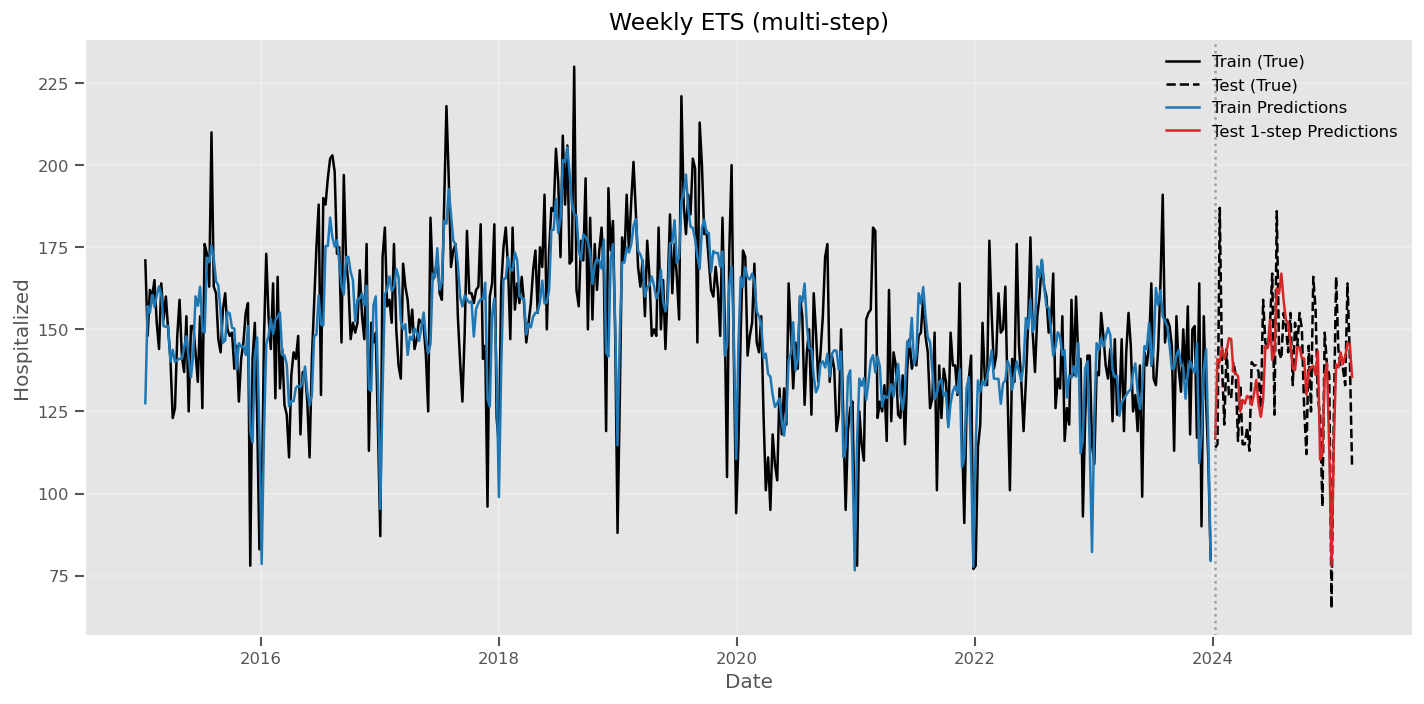

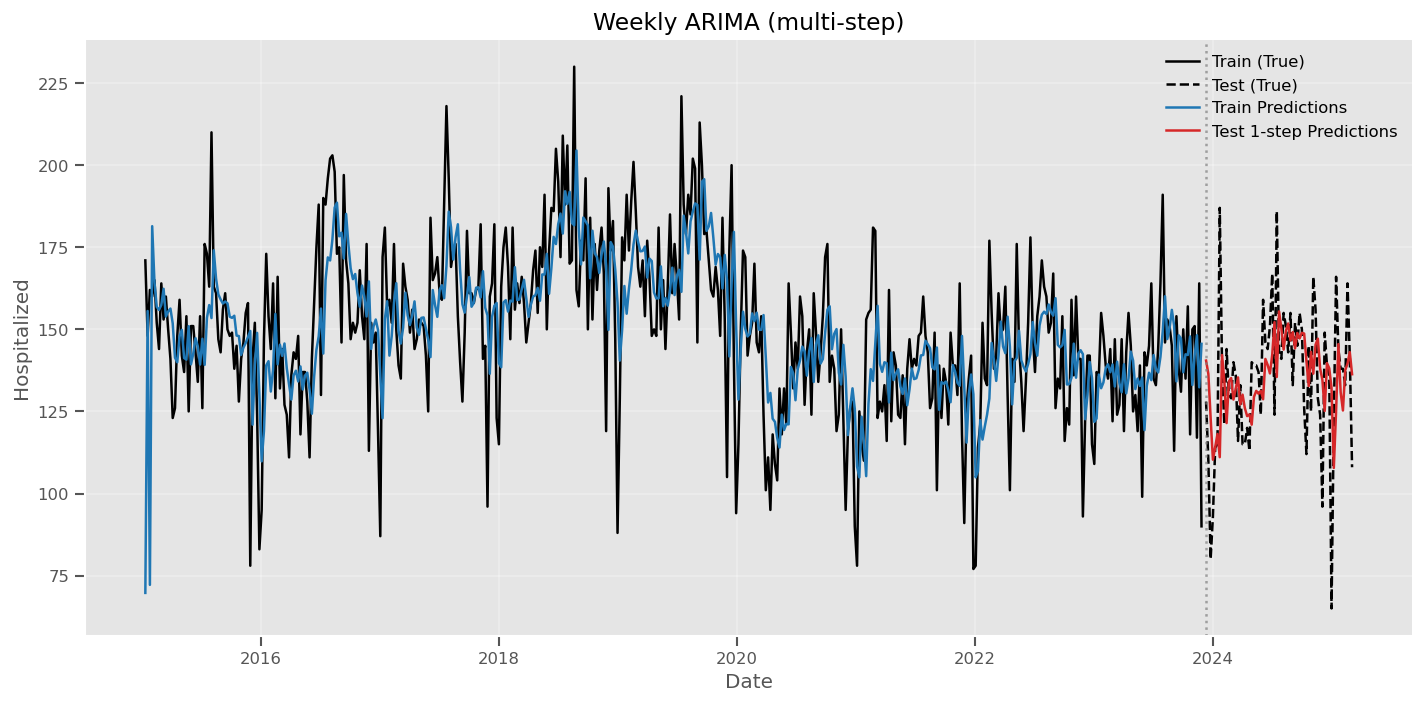

In [100]:
plot_forecast_results(results_ets_wk, title="Weekly ETS (multi-step)")
plot_forecast_results(results_arima_wk, title="Weekly ARIMA (multi-step)")


In [101]:
df_weekly_classical = results_to_df(
    [results_ets_wk, results_arima_wk, simple_sarima_results_wk]
)
save_results_csv(
    df_weekly_classical,
    save_dir=RESULTS_DIR / "national",
    filename="weekly_classical_models_hosp.csv",
)


Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\weekly_classical_models_hosp.csv


In [102]:
X_hosp_wk, y_hosp_sup_wk = build_feature_matrix(
    y_hosp_wk,
    lags=(1, 2, 3, 4, 5, 8, 12, 26, 52),
    rolling_windows=(4, 6, 8, 12, 26, 52),
    ewma_spans=(2, 4, 8, 12, 26, 52),
    add_calendar=True
)


In [103]:
train_end = "2023-12-31"

X_train_wk = X_hosp_wk.loc[:train_end]
y_train_wk = y_hosp_sup_wk.loc[:train_end]

X_test_wk = X_hosp_wk.loc[train_end:]
y_test_wk = y_hosp_sup_wk.loc[train_end:]

In [126]:
linear_results_wk = fit_evaluate_linear_models(X_train_wk, y_train_wk, X_test_wk, y_test_wk)


In [105]:
all_linear_results_wk = list(linear_results.values())
df_linear_wk = results_to_df(all_linear_results_wk)
save_results_csv(df_linear_wk, save_dir=RESULTS_DIR / "national", filename="weekly_linear_models_hosp.csv")

Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\weekly_linear_models_hosp.csv


In [106]:
tree_results_wk = fit_evaluate_boosting_models(X_train_wk, y_train_wk, X_test_wk, y_test_wk)

In [107]:
all_tree_results_wk = list(tree_results_wk.values())
df_tree_wk = results_to_df(all_tree_results_wk)
save_results_csv(df_tree_wk, save_dir=RESULTS_DIR / "national", filename="weekly_tree_models_hosp.csv")

Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national\weekly_tree_models_hosp.csv


In [109]:
importances_wk = get_boosting_feature_importances(tree_results_wk, X_train_wk)

In [110]:
feat_imp_df = pd.concat(
    {model: s for model, s in importances_wk.items()},
    axis=1
)

feat_imp_df

,XGBoost,LightGBM,CatBoost
ewma_12,0.115338,140,2.202243
ewma_2,0.111335,225,6.339144
lag_52,0.080878,437,20.234458
rollmean_4,0.069820,188,3.728461
quarter,0.064057,9,1.154933
rollmean_6,0.061796,151,3.148148
ewma_4,0.057058,184,3.472798
rollmean_12,0.053531,230,1.342941
year,0.049089,81,4.574372
month_cos,0.048160,153,5.476992


In [111]:
imp_norm_wk = feat_imp_df.divide(feat_imp_df.sum(axis=0), axis=1)


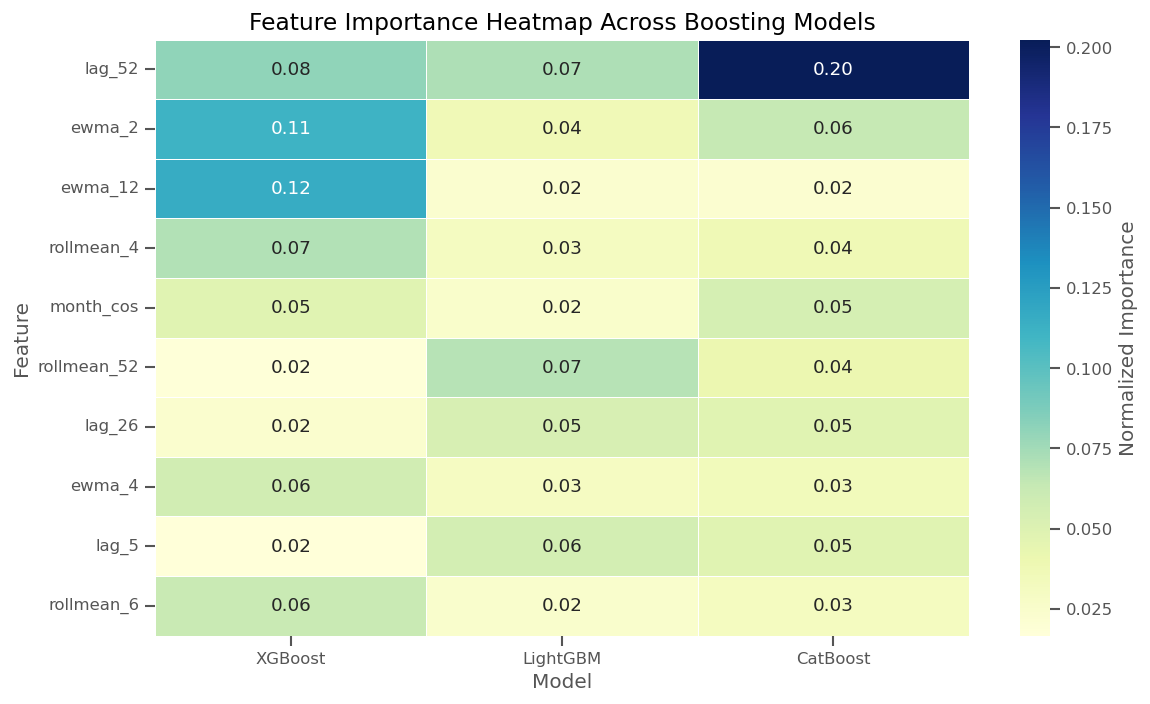

In [112]:
plot_importance_heatmap(imp_norm_wk, top_n=10)

In [113]:
import pandas as pd
import numpy as np

def get_single_linear_importance(
    estimator,
    feature_names: list[str],
    model_name: str,
    use_abs: bool = True,
) -> pd.Series:
    """
    Extract feature importance from a linear model inside a Pipeline.

    Assumes estimator is a Pipeline with a final step called 'model'
    having a .coef_ attribute (Ridge, Lasso, ElasticNet, PLSRegression).

    Parameters
    ----------
    estimator : sklearn Pipeline
        Fitted pipeline (StandardScaler -> model).
    feature_names : list of str
        Names of features (X_train.columns).
    model_name : str
        For labeling.
    use_abs : bool
        If True, return |coef| as importance. If False, keep signed coef.

    Returns
    -------
    importance : pd.Series
        Index = feature names, values = (possibly abs) coefficients,
        sorted descending by importance.
    """
    model = estimator.named_steps["model"]
    coefs = model.coef_

    # PLSRegression returns shape (n_features, 1)
    coefs = np.ravel(coefs)

    if use_abs:
        coefs = np.abs(coefs)

    s = pd.Series(coefs, index=feature_names, name=model_name)
    s = s.sort_values(ascending=False)
    return s


In [114]:
def get_linear_feature_importances(
    linear_results: dict,
    X_train: pd.DataFrame,
    use_abs: bool = True,
) -> dict[str, pd.Series]:
    """
    Compute feature importances (from coefficients) for all
    linear models in linear_results.

    Parameters
    ----------
    linear_results : dict
        Output of fit_evaluate_linear_models.
    X_train : pd.DataFrame
        Training features.
    use_abs : bool
        If True, use absolute value of coefficients.

    Returns
    -------
    importances_dict : dict
        Keys = model names ("Ridge", "Lasso", "ElasticNet", "PLS")
        Values = pd.Series (sorted feature importances).
    """
    feature_names = list(X_train.columns)
    importances_dict: dict[str, pd.Series] = {}

    for key, res in linear_results.items():
        est = res["estimator"]
        model_name = res["model_name"]

        importance_series = get_single_linear_importance(
            estimator=est,
            feature_names=feature_names,
            model_name=model_name,
            use_abs=use_abs,
        )
        importances_dict[key] = importance_series

    return importances_dict


In [117]:


lin_importances_wk = get_linear_feature_importances(linear_results, X_train_wk)

lin_importances_wk["Ridge"].head(10)



rollmean_26    11.418286
lag_52          8.718215
rollmean_52     8.394290
rollmean_8      7.075457
ewma_52         5.927208
ewma_26         5.793134
month_cos       4.748004
ewma_12         4.095032
month           3.623659
lag_5           3.466633
Name: Ridge, dtype: float64

In [118]:
def stack_importances(importances: dict[str, pd.Series]) -> pd.DataFrame:
    df = pd.concat(importances, axis=1)
    df.columns = df.columns.droplevel(0) if isinstance(df.columns, pd.MultiIndex) else df.columns
    return df

lin_imp_matrix = stack_importances(lin_importances_wk)
lin_imp_norm = lin_imp_matrix.divide(lin_imp_matrix.abs().sum(axis=0), axis=1)  # normalize per model


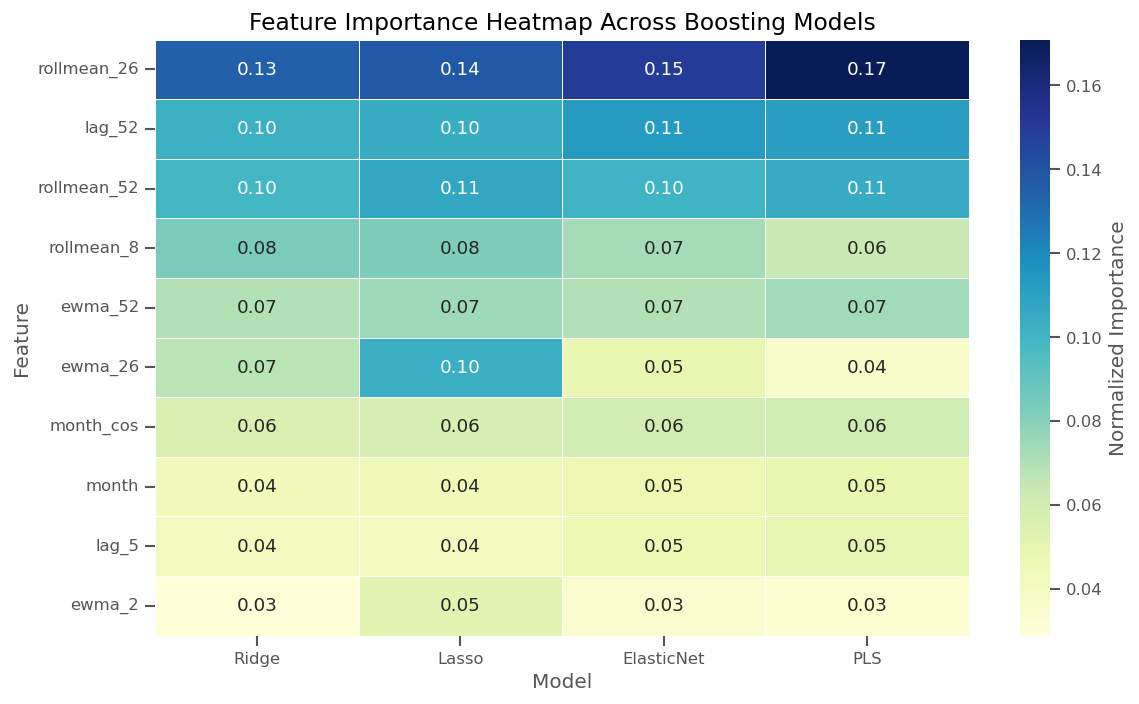

In [119]:
plot_importance_heatmap(lin_imp_norm, top_n=10)

In [124]:
# Classical models (monthly)
monthly_classical = [
    results_ets,
    results_arima,
    results_sarima,
    simple_sarima_results,
]

# Linear models (dict → list)
monthly_linear = list(linear_results.values())

# Boosting models (dict → list)
monthly_boost = list(tree_results.values())

# Combine everything
monthly_all_results = monthly_classical + monthly_linear + monthly_boost

monthly_table = results_to_df(monthly_all_results)
monthly_table.insert(0, "freq", "monthly")  # optional, nice to keep
monthly_table


,freq,model,train_MAE,train_RMSE,test_MAE,test_RMSE
0,monthly,ETS,37.165417,46.836048,23.220859,30.845659
1,monthly,"ARIMA(3, 1, 3)",59.892398,93.910746,42.329163,48.081904
2,monthly,"SARIMA(0, 1, 2)x(0, 1, 1, 12)",54.991659,94.348969,24.166562,31.451136
3,monthly,"SARIMA(1, 0, 1)x(1, 1, 1, 12)_multistep",59.285906,107.960649,20.791063,26.291973
4,monthly,Ridge,41.960380,49.803478,28.244328,36.985043
5,monthly,Lasso,41.601832,48.885431,26.537807,35.450795
6,monthly,ElasticNet,41.701810,49.369747,27.337821,36.179153
7,monthly,PLS(n_components=10),42.065650,49.459852,26.949236,35.481957
8,monthly,XGBoost,2.379750,3.015979,36.722984,43.529336
9,monthly,LightGBM,21.031899,25.948139,28.605285,38.655576


In [128]:
weekly_classical = [results_ets_wk, results_arima_wk, simple_sarima_results_wk]

# Linear models (weekly)
weekly_linear = list(linear_results_wk.values())

# Boosting models (weekly)
weekly_boost = list(tree_results_wk.values())

weekly_all_results = weekly_classical + weekly_linear + weekly_boost

weekly_table = results_to_df(weekly_all_results)
weekly_table.insert(0, "freq", "weekly")
weekly_table

,freq,model,train_MAE,train_RMSE,test_MAE,test_RMSE
0,weekly,"ETS(trend=add, seasonal=add, sp=52)",13.665117,17.134164,12.553954,15.705307
1,weekly,"ARIMA(2, 1, 3)_multistep",16.682507,21.984116,23.117093,27.838972
2,weekly,"SARIMA(1, 0, 1)x(1, 1, 1, 52)_multistep",16.542083,21.594902,14.892803,19.445485
3,weekly,Ridge,14.344561,18.034323,15.706414,19.738905
4,weekly,Lasso,14.345877,18.033352,15.713702,19.742873
5,weekly,ElasticNet,14.344174,18.043181,15.756171,19.770068
6,weekly,PLS(n_components=10),14.365212,18.043818,15.902084,19.814135
7,weekly,XGBoost,4.813753,6.259726,17.026418,20.951689
8,weekly,LightGBM,1.615069,2.194583,17.767947,21.883201
9,weekly,CatBoost,7.655670,9.662620,16.032349,20.109254


In [129]:



def fit_evaluate_naive_persistence(
    y: pd.Series,
    train_end: str,
) -> dict:
    """
    Naive persistence model: ŷ_t = y_{t-1}

    Works for any frequency (monthly, weekly, ...).
    Uses previous *observed* value as the forecast.

    Parameters
    ----------
    y : pd.Series
        Full time series (train + test), DatetimeIndex sorted.
    train_end : str
        Last timestamp included in the training period.

    Returns
    -------
    results : dict
        Same structure as for other models:
        - model_name
        - train_true, train_pred
        - test_true, test_pred
        - train_metrics, test_metrics
    """
    y = y.sort_index()

    # Split
    y_train = y.loc[:train_end]
    y_test = y.loc[train_end:].iloc[1:]   # all points after train_end

    # Build full one-step-ahead predictions via shift
    y_pred_full = y.shift(1)

    # Train predictions: use shifted values on train index, drop first NaN
    train_pred = y_pred_full.loc[y_train.index]
    train_true = y_train.copy()

    # Remove the first point where we cannot predict (no t-1)
    train_pred = train_pred.iloc[1:]
    train_true = train_true.iloc[1:]

    train_metrics = mae_rmse(train_true, train_pred)

    # Test predictions: also from shifted series, including the boundary
    test_pred = y_pred_full.loc[y_test.index]
    test_true = y_test.copy()

    test_metrics = mae_rmse(test_true, test_pred)

    return {
        "model_name": "NaivePersistence",
        "estimator": None,   # for API consistency
        "train_true": train_true,
        "train_pred": train_pred,
        "test_true": test_true,
        "test_pred": test_pred,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
    }


In [130]:
# y_hosp_monthly: monthly aggregated series (freq="MS")
naive_monthly = fit_evaluate_naive_persistence(
    y_hosp,
    train_end="2023-12-01",
)

naive_monthly

{'model_name': 'NaivePersistence',
 'estimator': None,
 'train_true': EventDate
 2015-02-01    623
 2015-03-01    664
 2015-04-01    612
 2015-05-01    611
 2015-06-01    635
              ... 
 2023-08-01    665
 2023-09-01    595
 2023-10-01    612
 2023-11-01    571
 2023-12-01    480
 Freq: MS, Name: Hospitalized, Length: 107, dtype: int64,
 'train_pred': EventDate
 2015-02-01    673.0
 2015-03-01    623.0
 2015-04-01    664.0
 2015-05-01    612.0
 2015-06-01    611.0
               ...  
 2023-08-01    666.0
 2023-09-01    665.0
 2023-10-01    595.0
 2023-11-01    612.0
 2023-12-01    571.0
 Freq: MS, Name: Hospitalized, Length: 107, dtype: float64,
 'test_true': EventDate
 2024-01-01    611
 2024-02-01    544
 2024-03-01    548
 2024-04-01    535
 2024-05-01    624
 2024-06-01    634
 2024-07-01    669
 2024-08-01    673
 2024-09-01    613
 2024-10-01    604
 2024-11-01    534
 2024-12-01    544
 2025-01-01    654
 2025-02-01    588
 Freq: MS, Name: Hospitalized, dtype: int64,
 '

In [131]:
# y_hosp_weekly: weekly aggregated series (freq="W-MON" or similar)
naive_weekly = fit_evaluate_naive_persistence(
    y_hosp_wk,
    train_end="2023-12-31",
)


In [132]:
monthly_all_results.append(naive_monthly)
weekly_all_results.append(naive_weekly)


In [135]:
monthly_table = results_to_df(monthly_all_results)
monthly_table.insert(0, "freq", "monthly")  # optional, nice to keep
monthly_table

,freq,model,train_MAE,train_RMSE,test_MAE,test_RMSE
0,monthly,ETS,37.165417,46.836048,23.220859,30.845659
1,monthly,"ARIMA(3, 1, 3)",59.892398,93.910746,42.329163,48.081904
2,monthly,"SARIMA(0, 1, 2)x(0, 1, 1, 12)",54.991659,94.348969,24.166562,31.451136
3,monthly,"SARIMA(1, 0, 1)x(1, 1, 1, 12)_multistep",59.285906,107.960649,20.791063,26.291973
4,monthly,Ridge,41.960380,49.803478,28.244328,36.985043
5,monthly,Lasso,41.601832,48.885431,26.537807,35.450795
6,monthly,ElasticNet,41.701810,49.369747,27.337821,36.179153
7,monthly,PLS(n_components=10),42.065650,49.459852,26.949236,35.481957
8,monthly,XGBoost,2.379750,3.015979,36.722984,43.529336
9,monthly,LightGBM,21.031899,25.948139,28.605285,38.655576


In [136]:
weekly_table = results_to_df(weekly_all_results)
weekly_table.insert(0, "freq", "weekly")
weekly_table

,freq,model,train_MAE,train_RMSE,test_MAE,test_RMSE
0,weekly,"ETS(trend=add, seasonal=add, sp=52)",13.665117,17.134164,12.553954,15.705307
1,weekly,"ARIMA(2, 1, 3)_multistep",16.682507,21.984116,23.117093,27.838972
2,weekly,"SARIMA(1, 0, 1)x(1, 1, 1, 52)_multistep",16.542083,21.594902,14.892803,19.445485
3,weekly,Ridge,14.344561,18.034323,15.706414,19.738905
4,weekly,Lasso,14.345877,18.033352,15.713702,19.742873
5,weekly,ElasticNet,14.344174,18.043181,15.756171,19.770068
6,weekly,PLS(n_components=10),14.365212,18.043818,15.902084,19.814135
7,weekly,XGBoost,4.813753,6.259726,17.026418,20.951689
8,weekly,LightGBM,1.615069,2.194583,17.767947,21.883201
9,weekly,CatBoost,7.655670,9.662620,16.032349,20.109254


### More error analysis on weekly national time series

In [138]:


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot


def get_residuals(results: dict, split: str = "test") -> pd.Series:
    """
    Return residuals for a given split: y_true - y_pred.
    split: "train" or "test"
    """
    if split == "train":
        y_true = results["train_true"]
        y_pred = results["train_pred"]
    elif split == "test":
        y_true = results["test_true"]
        y_pred = results["test_pred"]
    else:
        raise ValueError("split must be 'train' or 'test'")

    resid = y_true - y_pred
    resid.name = f"{results['model_name']}_resid_{split}"
    return resid


In [139]:
def plot_residual_diagnostics(results: dict, split: str = "test", lags: int = 24):
    """
    Residual diagnostics for a model:
    - time plot
    - histogram
    - ACF
    - PACF
    - QQ plot

    split: 'train' or 'test'
    """
    resid = get_residuals(results, split=split).dropna()
    name = results["model_name"]

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.ravel()

    # 1) Residuals over time
    resid.plot(ax=axes[0])
    axes[0].set_title(f"{name} residuals over time ({split})")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Residual")

    # 2) Histogram
    sns.histplot(resid, kde=True, ax=axes[1])
    axes[1].set_title("Residual histogram")

    # 3) ACF
    plot_acf(resid, ax=axes[2], lags=lags)
    axes[2].set_title("ACF of residuals")

    # 4) PACF
    plot_pacf(resid, ax=axes[3], lags=lags, method="ywm")
    axes[3].set_title("PACF of residuals")

    # 5) QQ plot
    qqplot(resid, line="s", ax=axes[4])
    axes[4].set_title("Q-Q plot")

    # 6) Empty / text
    axes[5].axis("off")
    axes[5].text(
        0.05, 0.5,
        f"Mean resid: {resid.mean():.3f}\nStd resid: {resid.std():.3f}",
        fontsize=11,
        va="center",
    )

    plt.tight_layout()
    plt.show()


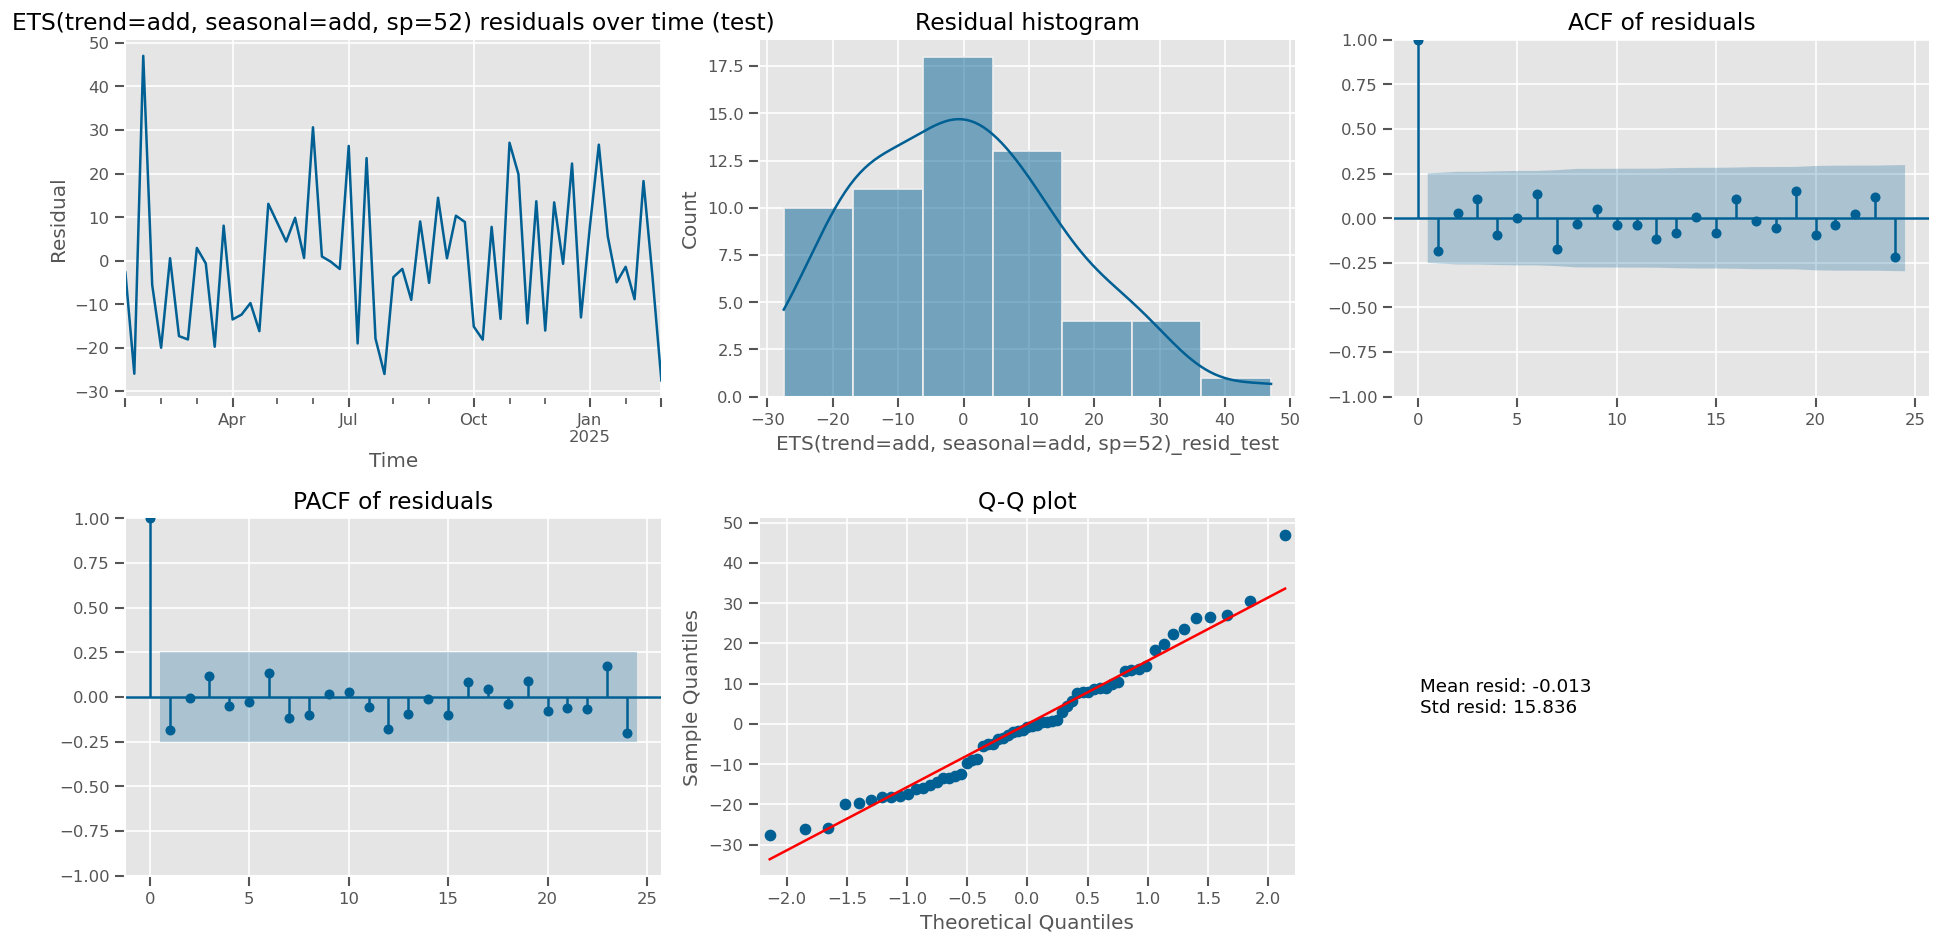

In [140]:
plot_residual_diagnostics(results_ets_wk, split="test", lags=24)


In [141]:
def compute_horizon_errors(results: dict) -> pd.DataFrame:
    """
    For multi-step forecasts from a single origin:
    horizon h = 1,2,...,len(test)
    error(h) = y_true(h) - y_pred(h)

    Returns a DataFrame with:
    - horizon
    - error
    - abs_error
    - sq_error
    """
    y_true = results["test_true"]
    y_pred = results["test_pred"]

    horizons = np.arange(1, len(y_true) + 1)
    error = y_true.values - y_pred.values

    df = pd.DataFrame({
        "horizon": horizons,
        "error": error,
    })
    df["abs_error"] = np.abs(df["error"])
    df["sq_error"] = df["error"] ** 2

    return df


def plot_horizon_error(results: dict):
    """
    Plot absolute error as a function of forecast horizon.
    """
    df = compute_horizon_errors(results)
    name = results["model_name"]

    plt.figure(figsize=(8, 4))
    plt.plot(df["horizon"], df["abs_error"], marker="o")
    plt.xlabel("Forecast horizon (steps ahead)")
    plt.ylabel("Absolute error")
    plt.title(f"Horizon vs absolute error – {name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


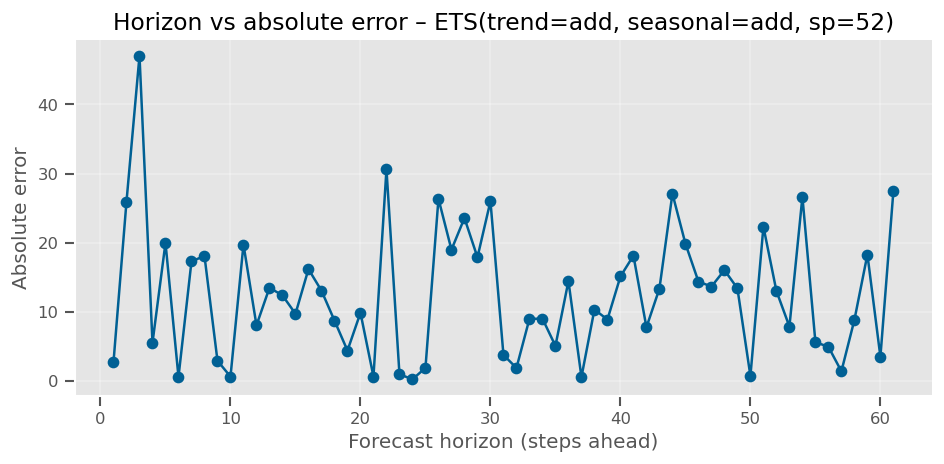

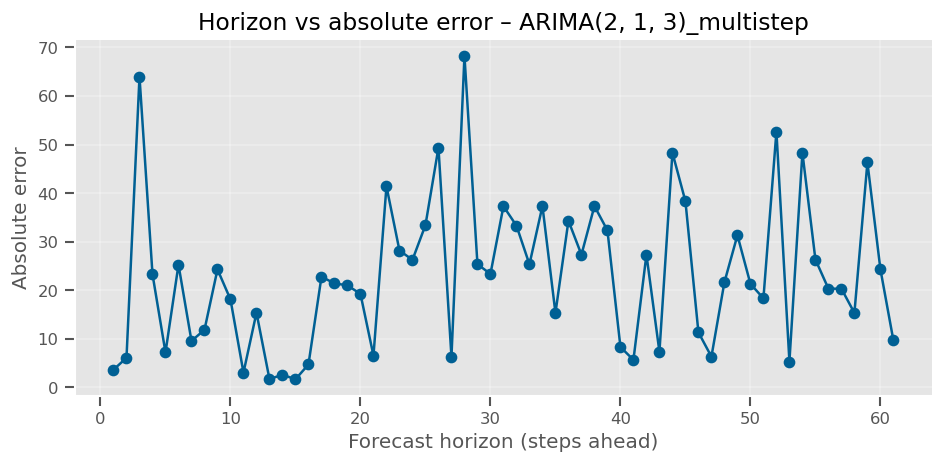

In [142]:
plot_horizon_error(results_ets_wk)
plot_horizon_error(results_arima_wk)


In [143]:
def plot_error_over_time(results: dict, split: str = "test", window: int = 4):
    """
    Plot residuals and rolling absolute error over time.
    window: rolling window (in periods) for smoothing abs error.
    """
    resid = get_residuals(results, split=split).dropna()
    abs_err = resid.abs()
    roll_abs_err = abs_err.rolling(window=window, min_periods=1).mean()

    name = results["model_name"]

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    resid.plot(ax=ax[0])
    ax[0].set_title(f"{name} residuals over time ({split})")
    ax[0].set_ylabel("Residual")
    ax[0].grid(True, alpha=0.3)

    abs_err.plot(ax=ax[1], label="|error|", alpha=0.5)
    roll_abs_err.plot(ax=ax[1], label=f"rolling |error| (w={window})")
    ax[1].set_title("Absolute error and rolling mean")
    ax[1].set_ylabel("Absolute error")
    ax[1].set_xlabel("Time")
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


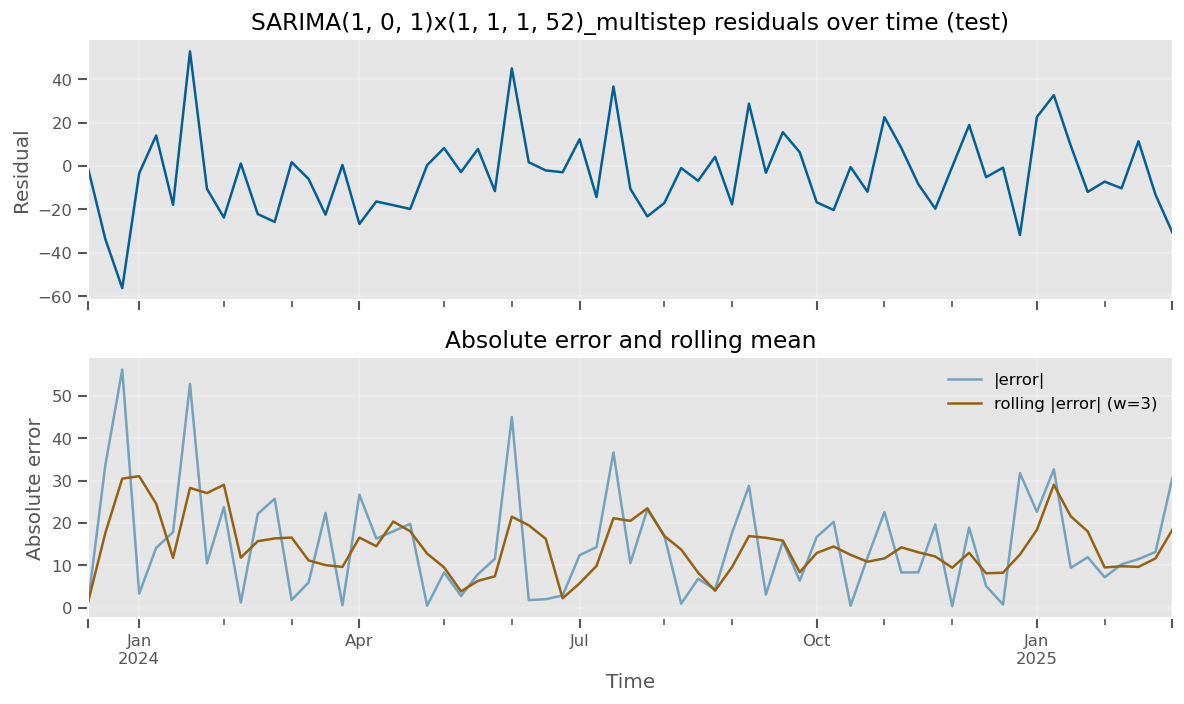

In [144]:
plot_error_over_time(simple_sarima_results_wk, split="test", window=3)


In [145]:
def error_by_weekofyear(results: dict, split: str = "test") -> pd.Series:
    """
    Compute mean absolute error per ISO week-of-year (1-53).
    Works best for weekly data.
    """
    if split == "train":
        y_true = results["train_true"]
        y_pred = results["train_pred"]
    else:
        y_true = results["test_true"]
        y_pred = results["test_pred"]

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
    }).dropna()

    iso = df.index.isocalendar()
    df["weekofyear"] = iso.week
    df["abs_error"] = (df["y_true"] - df["y_pred"]).abs()

    mae_by_week = df.groupby("weekofyear")["abs_error"].mean()
    mae_by_week.name = f"{results['model_name']}_MAE_by_week_{split}"
    return mae_by_week


def plot_error_by_weekofyear(results: dict, split: str = "test"):
    mae_by_week = error_by_weekofyear(results, split=split)
    name = results["model_name"]

    plt.figure(figsize=(10, 4))
    mae_by_week.plot(kind="bar")
    plt.xlabel("ISO week-of-year")
    plt.ylabel("Mean absolute error")
    plt.title(f"MAE by week-of-year ({split}) – {name}")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


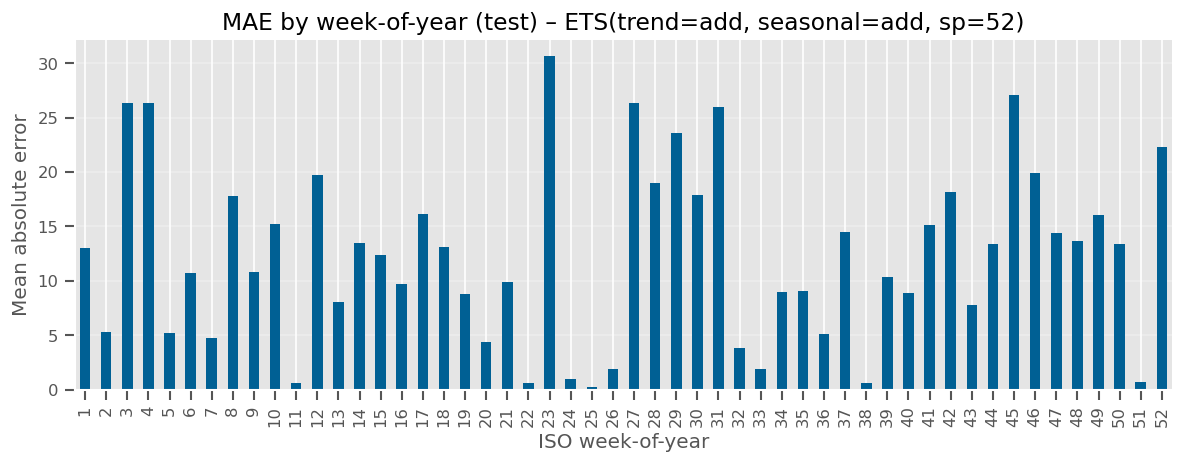

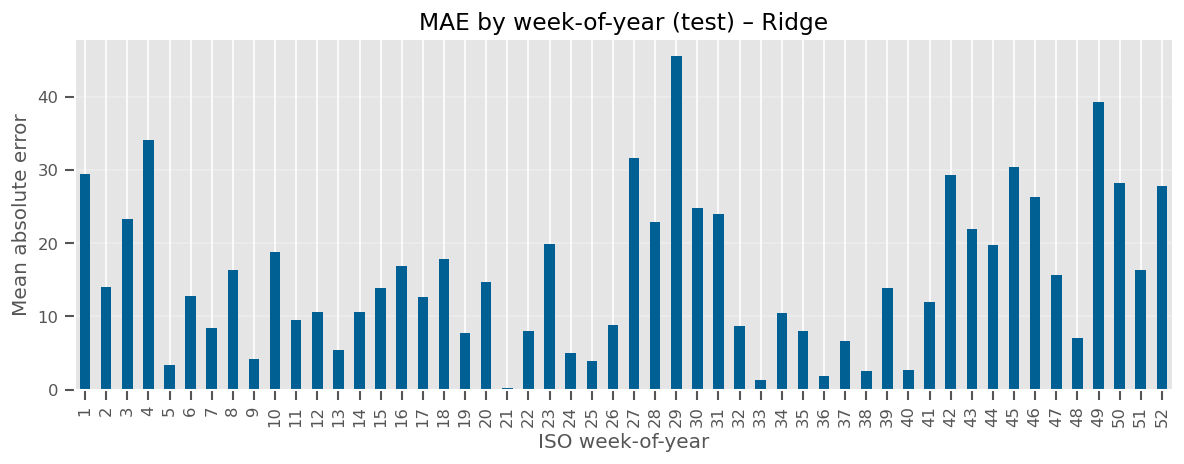

In [146]:
plot_error_by_weekofyear(results_ets_wk, split="test")
plot_error_by_weekofyear(linear_results_wk['Ridge'], split="test")


In [147]:
def bias_variance_decomposition(results: dict, split: str = "test") -> dict:
    """
    Compute bias and variance components of the error for a given split.

    Returns:
    - bias: mean(error)
    - var_error: variance(error)
    - mse: mean(error^2)
    - bias2: bias^2
    """
    resid = get_residuals(results, split=split).dropna()
    error = -resid * -1  # just to be explicit, resid = y_true - y_pred

    bias = error.mean()
    var_error = error.var()
    mse = (error ** 2).mean()
    bias2 = bias ** 2

    return {
        "bias": bias,
        "var_error": var_error,
        "mse": mse,
        "bias2": bias2,
    }


In [148]:
bv_test = bias_variance_decomposition(results_ets_wk, split="test")
print(bv_test)


{'bias': np.float64(-0.012841852068971617), 'var_error': 250.76745949906615, 'mse': np.float64(246.65668245322976), 'bias2': np.float64(0.00016491316456135061)}


In [149]:
def plot_train_test_error_distribution(results: dict, bins: int = 20):
    """
    Compare train vs test residual distributions.
    """
    resid_train = get_residuals(results, split="train").dropna()
    resid_test = get_residuals(results, split="test").dropna()
    name = results["model_name"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

    sns.histplot(resid_train, kde=True, bins=bins, ax=axes[0])
    axes[0].set_title(f"{name} – train residuals")
    axes[0].set_xlabel("Residual")
    axes[0].grid(True, alpha=0.3)

    sns.histplot(resid_test, kde=True, bins=bins, ax=axes[1], color="orange")
    axes[1].set_title(f"{name} – test residuals")
    axes[1].set_xlabel("Residual")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


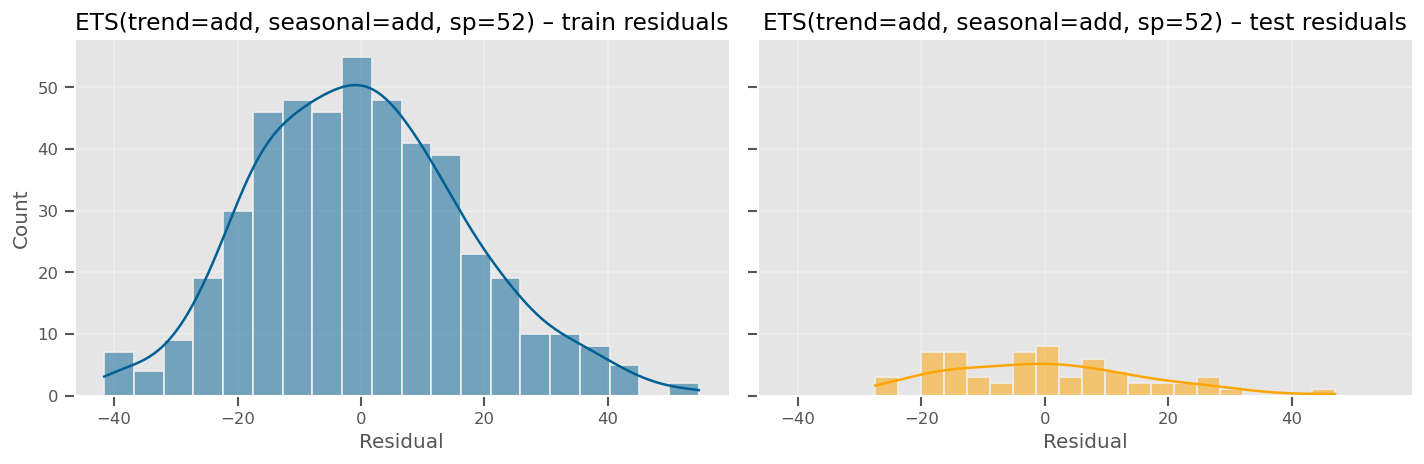

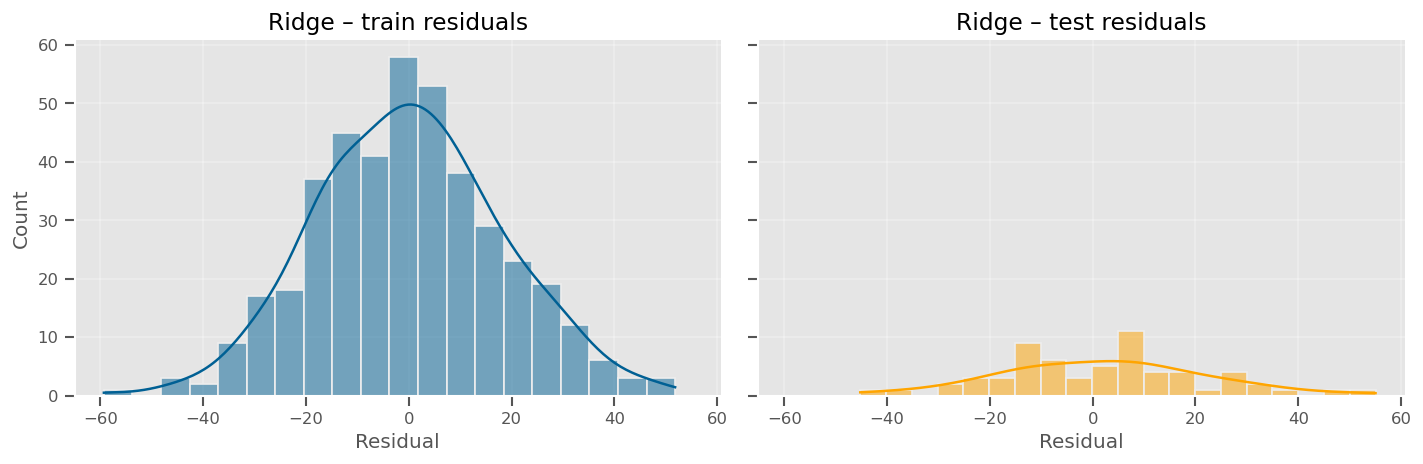

In [150]:
plot_train_test_error_distribution(results_ets_wk)
plot_train_test_error_distribution(linear_results_wk["Ridge"])
